#How can we predict NBA ticket price?

<img src="files/nba.jpg">

###by Bryan Baek, Walker Evans, and Takehiro Matsuzawa

#Table of Contents
* [I. How can we predict NBA ticket price?:](#How-can-we-predict-NBA-ticket-price?)
	* [I. Overview and Motivation:](#I.-Overview-and-Motivation:)
	* [II. Related Work:](#II.-Related-Work:)
    * [III Initial Questions:](#III.-Initial-Questions:)
		* [i. Data Source](#III.i-Data-Source)
		* [ii. Scrapping Method](#III.ii-Scraping-Method)
            * [1. Team Ranking](#1.--Team-Ranking)
            * [2. Salary](#2.-Salary)
            * [3. NBA Attendance](#3.-NBA-Attendance)
            * [4. Ticket Info from SeatGeek](#4.-Ticket-Info-from-SeatGeek)
        * [iii. Cleanup Data](#III.iii-Cleanup-Data)
            * [1. NBA attendence data](#1.-NBA-attendence-data)
            * [2. City Information](#2.-City-Information)
            * [3. Ticket Data](#3.-Ticket-Data)
            * [4. Combine Ranking and Attendance](#4.-Combine-Ranking-and-Attendance)
            * [5. Salary Data of NBA](#5.-Salary-Data-of-NBA)
            * [6. Merge Data](#6.-Merge-Data)
            * [7. Remove unnecessary columns](#7.-Remove-unnecessary-columns)
            * [8. Date Information](#8.-Date-Information)
    * [IV Exploratory Data Analysis:](#IV-Exploratory-Data-Analysis:)      
        * [i. Team Performance](#IV.i-Team-Performance)
            * [1. Winning Percentage By Team](#1.-Winning-Percentage-By-Team)
            * [2. Winning Streak By Team](#2.-Winning-Streak-By-Team)
            * [3. Winning Streak Over Time](#3.-Winning-Streak-Over-Time)
            * [4. Winning Percentage Over Time](#4.-Winning-Percentage-Over-Time)
            * [5. Winning Percentage Over Time in One Chart](#5.-Winning-Percentage-Over-Time-in-One-Chart)
            * [6. Winning Streaks Over Time in One Chart](#6.-Winning-Streaks-Over-Time-in-One-Chart)
        * [ii. Salary](#IV.ii-Salary)
            * [1. Salary of Stars on Each Team](#1.-Salary-of-Stars-on-Each-Team)
            * [2. Number of Stars on Each Team](#2.-Number-of-Stars-on-Each-Team)
        * [iii. Attendance](#IV.iii-Attendance)
            * [1. Number of Audience](#1.-Number-of-Audience)
            * [2. Ratio of Audience to Capacity](#2.-Ratio-of-Audience-to-Capacity)
        * [iv. Ticket Prices](#IV.iv-Ticket-Prices)
            * [1. Histogram of Lowest Good Ticket Prices](#1.-Histogram-of-Lowest-Good-Ticket-Prices)
            * [2. Away Team Rank and Ticket Price](#2.-Away-Team-Rank-and-Ticket-Price)
            * [3. Ticket Price Change By Team](#3.-Ticket-Price-Change-By-Team)
            * [4. Time Evolution of Lowest Good Ticket Price per NBA Teams](#4.-Time-Evolution-of-Lowest-Good-Ticket-Price-per-NBA-Teams)
            * [5. Single Factor Analysis](#5.-Single-Factor-Analysis)
            * [6. Ticket For Each Team](#6.-Ticket-For-Each-Team)
            * [7. Number of Available Tickets for Each Team](#7.-Number-of-Available-Tickets-for-Each-Team)
            
            
    


In [112]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from bs4 import BeautifulSoup
import requests
import html5lib
import datetime
import os
import time
import re

#I. Overview and Motivation:

Ticket prices are very volatile. The ticket themselves are priced based on supply and demand. Thus, without a sure way to price the tickets, the tickets are priced arbitrarily, and it's either priced higher or lower than the market demand. Thus, there is a deadweight loss associated with the trade of ticket prices. We see this happen a lot on third-party ticket website like Stubhub or SeatGeek. 

With this project, we attempted to gather, explore, and exploit ticket prices posted on Seatgeek.com and their relationship to sports data. SeatGeek is 3rd party website for tickets - users are able to buy/sell tickets for any sports/concerts. 

Thus, we wanted to look at how different factors affect the ticket pricing. 
1. What factors affect the ticket price at a given moment?
2. Using today's information, can we predict the ticket price a week from now?

We looked at NBA which is currently in season at the time of the project. We used SeatGeek's API to pull information about an event's ticket information. Unfortunately, due to the API policy, we were not able to scrape the information about individual tickets. Next, we scraped relevant sports data (i.e. ranking, winning percentage) from ESPN. These are the questions we attempted to answer through our data science process, using some familiar algorithms (eg. ridge, lasso regression) in an effort to predict the ticket price change.

During the summer, Bryan Baek did a case study on Boston's AceTickets. Event tickets are interesting to study among other commodities. First, it loses its value after the time of the event has passed. Thus, the ticket price changes quite dramatically depending on how close the ticket is from the event time. Next, many different factors affect the price. Because of limited quantity of tickets for a given event, the price is heavily influenced by its demand. The demand can be influenced by many different factors. One would pay higher to watch a really good team, or one would pay more to watch a famous sport star like Kobe Bryant before he retires in 2016 even if his team is performing very poorly. In addition, one would treat a basketball ticket differently if the game was on a weekend or holiday vs Monday or Tuesday night. 

#II. Related Work: 

Websites like Kayak and Seatgeek try to educate the consumers by displaying a "good deal" chart for airplane tickets and event tickets, respectively. The data scientists at these places conduct their own analogy (http://chairnerd.seatgeek.com/the-math-behind-ticket-bargains/). Unfortunately, the general public does not have the access to the API that looks at individual tickets and seating. 



#III. Initial Questions: 

We initially tried to answer how ticket prices evolve over time depending on team performance and seat information factors. However, the open API only shows you a general ticket information. Thus, you only see lowest, lowest good, average, and highest ticket price of **an event.** The lowest good ticket price refers to the cheapest ticket that SeatGeek algorithm deems it's a good deal. Highest ticket price was deemed too volatile, and the average ticket price would be subject to too much variation; it would have confounding effect from the distribution for the ticket prices that we can not account for. The lowest ticket price has a problem as well; it might show you the most undesirable ticket such as standing ticket or a seat with a blocked/poor view. Thus, we rephrased our original question to answer how different factors affect the lowest good deal ticket price. The factors include ticket information from SeatGeek: location/venue, number of tickets, date of the game, number of days away from the game. We chose to ignore SeatGeek's assigned score on the venues and home/away teams because they were calculated in black-box setting and we don't know their method of derivation. We also looked at sports data: the number of highly-paid stars/winning percentage/winning streak of home and away teams, its current rank in the NBA. We looked at the percentage of attendance data on the respective teams playing; higher percentage would mean that their team has a lot of attendees. 

##III.i Data Source

1. Sports Data
ESPN proved to have the most useful layout displaying the sports standings information. Its data was clean, so scraping was consistent. Every day we scraped NBA standings information to reflect their dynamic nature (http://espn.go.com/nba/standings/_/group/league). We have more than a week worth of data.

2. Salaries Data
Next, we scraped information on top 40 salary in NBA from ESPN.com (http://espn.go.com/nba/salaries/_/year/2015). We used salary as an indicator of popularity/performance of players. It would account for people watching top players regardless of the team's performance. (i.e. Kobe Bryant)

3. Attendance Data
We scraped information on Home and Road attendnace of a NBA team from ESPN (http://espn.go.com/nba/attendance). This was collected daily because the average for home and road attendance would change as the season progressed. 

4. Ticket Data
We used SeatGeek's API to collect ticket information on entire NBA games from November to April. We collected more than a week worth of data. 

##III.ii Scraping Method
In the beginning, we used a scraping method similar to what we did in Problem Set 1 in CS109/Stat121 using JSON and BeautifulSoup. However, some websites were easier to use pandas.get_html which pulled pandas-like data structure from the collected JSON file. Also, the scraped data only reflect the data scraped at the moment, and there is no way to access historical data. Thus, we had to reguarly scrape data to build our database. 

In [113]:
#collect today's date for later storage issue
today=datetime.date.today()

##1.  Team Ranking

In [114]:
r1 = requests.get("http://espn.go.com/nba/standings/_/group/league")
text1 = r1.text
#pandas' read_html grabs table-like data from the web
bball_data=pd.read_html(text1)
#copy the dataset so we can change it
NBA=bball_data[0].copy()
#renaming columns to make sure we don't have weird spelling issue
NBA=NBA.rename(columns = {'Unnamed: 0':'Teams'})
#changing the format of certain values
NBA['HOME'] = NBA['HOME'].astype(str)
NBA['ROAD'] = NBA['ROAD'].astype(str)
NBA['DIV'] = NBA['DIV'].astype(str)
NBA['CONF'] = NBA['CONF'].astype(str)
NBA['L10'] = NBA['L10'].astype(str)
#saving as a csv
NBA.to_csv("Sports_Data/NBA" + str(today) + ".csv", encoding='utf-8')

In [115]:
NBA.head(2)

Teams   W  L    PCT   GB  HOME  ROAD  DIV  CONF    PPG  OPP PPG  DIFF STRK   L10
0  Golden State WarriorsGS  23  0  1.000    -  10-0  13-0  6-0  15-0  115.8    101.2  14.6  W23  10-0
1      San Antonio SpursSA  18  4  0.818  4.5  11-0   7-4  3-1   9-2  100.2     88.3  11.9   W4   9-1

## 2. Salary

In [116]:
r3 = requests.get("http://espn.go.com/nba/salaries/_/year/2015")
text3 = r3.text
NBAsalary_data=pd.read_html(text3)
NBA_salary=NBAsalary_data[0].copy()
NBA_salary.columns = NBA_salary.iloc[0]
NBA_salary.reindex(NBA_salary.index.drop(0))
NBA_salary = NBA_salary[NBA_salary.RK != 'RK'].reset_index(drop=True)
NBA_salary['SALARY'] = NBA_salary['SALARY'].str.replace(r'[$,]', '').astype('float')
NBA_salary.to_csv("Salary/NBA" + str(today) + ".csv", encoding='utf-8')

In [117]:
NBA_salary.head(2)

0 RK             NAME                TEAM    SALARY
0  1  Kobe Bryant, SF  Los Angeles Lakers  23500000
1  2  Joe Johnson, SF       Brooklyn Nets  23180790

##3. NBA Attendance

In [118]:
r4 = requests.get("http://espn.go.com/nba/attendance")
text4 = r4.text
NBAattn_data=pd.read_html(text4)
NBA_attendance=NBAattn_data[0].copy()
NBA_attendance.columns = NBA_attendance.iloc[1]
NBA_attendance=NBA_attendance.reindex(NBA_attendance.index.drop(0))
NBA_attendance=NBA_attendance[NBA_attendance.RK != 'RK'].reset_index(drop=True)
NBA_attendance.to_csv("Attendance/NBA" + str(today) + ".csv", encoding='utf-8')

In [119]:
NBA_attendance.head(2)

1 RK       TEAM GMS   TOTAL    AVG    PCT GMS    AVG   PCT GMS    AVG   PCT
0  1      Bulls  10  217165  21716  103.8   8  17164  87.7  18  19693  96.9
1  2  Cavaliers  11  226182  20562  100.0  10  19188  98.1  21  19907  99.1

##4. Ticket Info from SeatGeek

In [120]:
teams = []
r = requests.get("https://en.wikipedia.org/wiki/National_Basketball_Association")
text = r.text
soup = BeautifulSoup(text, 'html.parser')
rows = soup.find("table", attrs={"class": "navbox wikitable"}).find_all("td")
for row in rows:
    elements = row.find_all("b")
    for el in elements:
        teams.append(el.text)
#printing to check        
print len(teams)

30


In [121]:
count = 0
for team in teams:
    team_lower = team.lower()
    team_final = team_lower.replace(" ", "+")
    r = requests.get('http://api.seatgeek.com/2/events?q=' + team_final + '&per_page=1000')
    js = r.json()
    events = js["events"]

    df = pd.DataFrame()

    if count == 0:
        for event in events:
            keys =  event.keys()
            break

    for key in keys:
        lst = []
        listing_count = []
        avg_price = []
        lowest_price_good_deal = []
        lowest_price = []
        highest_price = []
        address = []
        city = []
        country = []
        display_location = []
        extended_address = []
        venueid = []
        location = []
        venuename = []
        postal_code = []
        venuescore = []
        venueslug = []
        state = []
        timezone = []
        url = []
       
        for event in events:
            if key == "stats":
                listing_count.append(event[key]["listing_count"])
                avg_price.append(event[key]["average_price"])
                lowest_price_good_deal.append(event[key]["lowest_price_good_deals"])
                lowest_price.append(event[key]["lowest_price"])
                highest_price.append(event[key]["highest_price"])
            elif key == "venue":
                address.append(event[key]["address"])
                city.append(event[key]["city"])
                country.append(event[key]["country"])
                display_location.append(event[key]["display_location"])
                extended_address.append(event[key]["extended_address"])
                venueid.append(event[key]["id"])
                location.append(event[key]["location"])
                venuename.append(event[key]["name"])
                postal_code.append(event[key]["postal_code"])
                venuescore.append(event[key]["score"])
                venueslug.append(event[key]["slug"])
                state.append(event[key]["state"])
                timezone.append(event[key]["timezone"])
                url.append(event[key]["url"])
            else:
                lst.append(event[key])
        if key == "stats":
            df["listing_count"] = listing_count
            df["avg_price"] = avg_price
            df["lowest_price_good_deal"] = lowest_price_good_deal
            df["lowest_price"] = lowest_price
            df["highest_price"] = highest_price
        elif key == "venue":
            df["address"] = address
            df["city"] = city
            df["country"] = country
            df["display_location"] = display_location
            df["extended_address"] = extended_address
            df["venueid"] = venueid
            df["location"] = location
            df["venuename"] = venuename
            df['postal_code'] = postal_code
            df["venuescore"] = venuescore
            df["venueslug"] = venueslug
            df["venuestate"] = state
            df["venuetimezone"] = timezone
            df['url'] = url
        else:
            df[key] = lst

    if count == 0:
        fulldf = df
    else:
        fulldf = fulldf.append(df, ignore_index = True)
    count = count + 1

In [122]:
# clean the data
# rename score as ticketscore to distinguish it from other scores
fulldf=fulldf.rename(columns = {'score':'ticket_score'})

# make sure you only have nba games
fulldf = fulldf.loc[fulldf['type'] == "nba"]
# get rid of the all-star game
fulldf = fulldf.loc[fulldf['title'] != "NBA All-Star Game"]
fulldf = fulldf.loc[fulldf['title'] != "NBA All-Star Celebrity Game"]
fulldf = fulldf.loc[fulldf['title'] != "NBA All-Star Rising Stars Challenge"]

# drop unnecessary columns
fulldf = fulldf.drop("time_tbd", 1)
fulldf = fulldf.drop("taxonomies", 1)
fulldf = fulldf.drop("links", 1)
fulldf = fulldf.drop("url", 1)
fulldf = fulldf.drop("display_location", 1)
fulldf = fulldf.drop("venueslug", 1)
fulldf = fulldf.drop("venuetimezone", 1)
fulldf = fulldf.drop("date_tbd", 1)
fulldf = fulldf.drop("type", 1)
fulldf = fulldf.drop("location", 1)

# sources: http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

In [123]:
# put teams in separate columns
teams_playing = fulldf.title
away_teams = []
home_teams = []
for teams_pl in teams_playing:
    split = teams_pl.split(" at ")
    away_teams.append(split[0])
    home_teams.append(split[1])
    
fulldf["home_team"] = home_teams
fulldf["away_team"] = away_teams
#fulldf = fulldf.drop("title", 1)

# if error here, examine data for exceptions and remove. Ie: all-star games.

In [124]:
# calculate days away
datetimes = fulldf["datetime_utc"]
date = []
timeutc = []
daysaway = []
toddate = datetime.datetime.strptime(time.strftime("%Y-%m-%d"), "%Y-%m-%d").date()

for dattime in datetimes:
    futdate = datetime.datetime.strptime(dattime.split("T")[0],"%Y-%m-%d").date()
    timeaway = futdate - toddate
    daysaway.append(int(timeaway.days))
    date.append(dattime.split("T")[0])
    timeutc.append(dattime.split("T")[1])
fulldf["dateutc"] = date
fulldf["timeutc"] = timeutc
fulldf["daysaway"] = daysaway
# sources: http://www.cyberciti.biz/faq/howto-get-current-date-time-in-python/

In [125]:
# reset index
fulldf = fulldf.reset_index()

# save as a CSV
#fulldf.to_csv("/Users/baekstboy/Documents/Senior/Stat121/ActiveFPData/basketballdf" + str(toddate) + ".csv")
# sources: http://chrisalbon.com/python/pandas_saving_dataframe_as_csv.html

#III.iii Cleanup Data

###1. NBA attendence data

In [126]:
NBA_attendance=pd.read_csv('Attendance/NBA2015-11-29.csv', index_col=0)
#resetting team names to calibrate to other data
NBA_attendance.loc[NBA_attendance['TEAM']=='Bulls','TEAM']='Chicago Bulls'
NBA_attendance.loc[NBA_attendance['TEAM']=='Cavaliers','TEAM']='Cleveland Cavaliers'
NBA_attendance.loc[NBA_attendance['TEAM']=='Mavericks','TEAM']='Dallas Mavericks'
NBA_attendance.loc[NBA_attendance['TEAM']=='Raptors','TEAM']='Toronto Raptors'
NBA_attendance.loc[NBA_attendance['TEAM']=='NY Knicks','TEAM']='New York Knicks'
NBA_attendance.loc[NBA_attendance['TEAM']=='Heat','TEAM']='Miami Heat'

NBA_attendance.loc[NBA_attendance['TEAM']=='Warriors','TEAM']='Golden State Warriors'
NBA_attendance.loc[NBA_attendance['TEAM']=='Jazz','TEAM']='Utah Jazz'
NBA_attendance.loc[NBA_attendance['TEAM']=='Trail Blazers','TEAM']='Portland Trail Blazers'
NBA_attendance.loc[NBA_attendance['TEAM']=='Raptors','TEAM']='Toronto Raptors'
NBA_attendance.loc[NBA_attendance['TEAM']=='Clippers','TEAM']='Los Angeles Clippers'
NBA_attendance.loc[NBA_attendance['TEAM']=='Lakers','TEAM']='Los Angeles Lakers'

NBA_attendance.loc[NBA_attendance['TEAM']=='Spurs','TEAM']='San Antonio Spurs'
NBA_attendance.loc[NBA_attendance['TEAM']=='Thunder','TEAM']='Oklahoma City Thunder'
NBA_attendance.loc[NBA_attendance['TEAM']=='Wizards','TEAM']='Washington Wizards'
NBA_attendance.loc[NBA_attendance['TEAM']=='Celtics','TEAM']='Boston Celtics'
NBA_attendance.loc[NBA_attendance['TEAM']=='Rockets','TEAM']='Houston Rockets'
NBA_attendance.loc[NBA_attendance['TEAM']=='Kings','TEAM']='Sacramento Kings'

NBA_attendance.loc[NBA_attendance['TEAM']=='Magic','TEAM']='Orlando Magic'
NBA_attendance.loc[NBA_attendance['TEAM']=='Suns','TEAM']='Phoenix Suns'
NBA_attendance.loc[NBA_attendance['TEAM']=='Grizzlies','TEAM']='Memphis Grizzlies'
NBA_attendance.loc[NBA_attendance['TEAM']=='Pelicans','TEAM']='New Orleans Pelicans'
NBA_attendance.loc[NBA_attendance['TEAM']=='Hornets','TEAM']='Charlotte Hornets'
NBA_attendance.loc[NBA_attendance['TEAM']=='Pacers','TEAM']='Indiana Pacers'

NBA_attendance.loc[NBA_attendance['TEAM']=='Hawks','TEAM']='Atlanta Hawks'
NBA_attendance.loc[NBA_attendance['TEAM']=='Pistons','TEAM']='Detroit Pistons'
NBA_attendance.loc[NBA_attendance['TEAM']=='76ers','TEAM']='Philadelphia 76ers'
NBA_attendance.loc[NBA_attendance['TEAM']=='Nets','TEAM']='Brooklyn Nets'
NBA_attendance.loc[NBA_attendance['TEAM']=='Bucks','TEAM']='Milwaukee Bucks'
NBA_attendance.loc[NBA_attendance['TEAM']=='Timberwolves','TEAM']='Minnesota Timberwolves'
NBA_attendance.loc[NBA_attendance['TEAM']=='Nuggets','TEAM']='Denver Nuggets'

NBA_attendance['AVG']=NBA_attendance['AVG'].astype('float')
NBA_attendance.columns = ['RK','home_team','HomeGames', 'HomeTotal','HomeAVG','HomePCT','AwayGames','AwayAVG','AwayPCT','TotalGames', 'TotalAVG','TotalPCT']
NBA_attendance.head(2)

RK            home_team  HomeGames  HomeTotal  HomeAVG  HomePCT  AwayGames  AwayAVG  AwayPCT  TotalGames  TotalAVG  TotalPCT
0   1        Chicago Bulls          6     130800    21800    104.2          8    17164     87.7          14     19150      95.1
1   2  Cleveland Cavaliers          9     185058    20562    100.0          8    19296     97.2          17     19966      98.7

###2. City Information

In [127]:
web='https://en.wikipedia.org/wiki/List_of_American_and_Canadian_cities_by_number_of_major_professional_sports_franchises#cite_note-CFL_teams-8'
team1 = requests.get(web)
capTable = BeautifulSoup(team1.text)
resultTable= capTable.find_all("table",{'class':"wikitable sortable"})[0]

resultTable = resultTable.find_all('tr')
paragraphs = []
#when you scrape the data, get the data as table
for num in range(len(resultTable)):
    if num==0:
        elem=resultTable[num].find_all('th')
    else:
        elem=resultTable[num].find_all('td')
    result=[]
    for elem1 in elem:
        result.append(elem1)
    paragraphs.append(result)
    
CLEAN = re.compile('\s+')
newpar=[]
#clean the data
for elem in paragraphs:
    elem = [CLEAN.sub(' ', a.text).strip() for a in elem]
    newpar.append(elem)

#make a new data frame called numCity based on scraping
numCity = pd.DataFrame(newpar)
#make the first row as the column names
numCity.columns = numCity.iloc[0]
#drop the first row
numCity=numCity.drop(numCity.index[0])

#Remove unnecessary letters
numCity[numCity.columns[6]] = numCity[numCity.columns[6]].str[:1]
numCity[numCity.columns[7]] = numCity[numCity.columns[7]].str[:1]
numCity[numCity.columns[8]] = numCity[numCity.columns[8]].str[:1]
numCity[numCity.columns[9]] = numCity[numCity.columns[9]].str[:1]

#Get a list of necessary columns
columnsTeam=[numCity.columns[0],numCity.columns[3],numCity.columns[4],numCity.columns[5],numCity.columns[6],numCity.columns[7],numCity.columns[8],numCity.columns[9]]

#make a new data frame which only has necessary column names
dfCity = pd.DataFrame(numCity,index=numCity.index, columns=columnsTeam)
dfCity.columns = ['City','Population','B4','B6','NFL','MLB','NBA','NHL']

#change the column name 'Minneapolis–Saint Paul' into 'Minneapolis'
dfCity['City'][13]='Minneapolis'
dfCity=dfCity.drop(dfCity.index[len(dfCity)-1])

#change the data types
dfCity[dfCity.columns[2]] = dfCity[dfCity.columns[2]].astype(float)
dfCity[dfCity.columns[3]] = dfCity[dfCity.columns[3]].astype(float)
dfCity[dfCity.columns[4]] = dfCity[dfCity.columns[4]].astype(float)
dfCity[dfCity.columns[5]] = dfCity[dfCity.columns[5]].astype(float)
dfCity[dfCity.columns[6]] = dfCity[dfCity.columns[6]].astype(float)
dfCity[dfCity.columns[7]] = dfCity[dfCity.columns[7]].astype(float)

#change the data type of population into float
dfCity['Population']=dfCity['Population'].str.replace(',', '').astype('float')
dfCity.head()

City  Population  B4  B6  NFL  MLB  NBA  NHL
1           New York City    20630000   9  11    2    2    2    3
2             Los Angeles    15058000   6   7    0    2    2    2
3  San Francisco Bay Area     5929000   6   7    2    2    1    1
4                 Chicago     9156000   5   6    1    2    1    1
5       Dallas-Fort Worth     6174000   4   5    1    1    1    1

###3. Ticket Data

In [128]:
filenames = []
dates = []
#get the ticket data of November
start = ("2015-11-")
for i in range(25,31):
    dates.append(start + str(i))
    filenames.append(str("Tickets Data/basketballdf") + start + str(i) + str(".csv"))

#get the ticket data of December
start = ("2015-12-")
for i in range(1,7):
    if i != 2:
        dates.append(start + str("0") + str(i))
        filenames.append(str("Tickets Data/basketballdf") + start + str("0") + str(i) + str(".csv"))


fulldf = pd.DataFrame()

for count in range(len(filenames)):
    loadin = pd.DataFrame.from_csv(filenames[count])
    loadin["dateloaded"] = dates[count]
    fulldf=fulldf.append(loadin, ignore_index = True)

    
#change the column names of data frame to merge data sets later
fulldf['City']=fulldf['city']
fulldf.loc[fulldf['City']=='Washington','City']='Washington, D.C.'
fulldf.loc[fulldf['City']=='Dallas','City']='Dallas-Fort Worth'
fulldf.loc[fulldf['City']=='New York','City']='New York City'
fulldf.loc[fulldf['City']=='Brooklyn','City']='New York City'
fulldf.loc[fulldf['City']=='Oakland','City']='San Francisco Bay Area'
fulldf.loc[fulldf['City']=='Auburn Hills','City']='Detroit'

fulldf['home_team'] = fulldf['home_team'].str[:]
fulldf['away_team'] = fulldf['away_team'].str[:]

fulldf = fulldf.drop("index", 1)
fulldf.head(2)

listing_count  avg_price  lowest_price_good_deal  lowest_price  highest_price       datetime_local           created_at          address    city country  extended_address  venueid  venuename postal_code  venuescore venuestate        announce_date         short_title         datetime_utc  ticket_score datetime_tbd    visible_until_utc       id       home_team           away_team  hometeamscore  awayteamscore     dateutc   timeutc  daysaway  dateloaded    City
0             35         56                      27            27            257  2015-11-25T19:30:00  2015-08-13T00:00:00  100 Legends Way  Boston      US  Boston, MA 02114     1544  TD Garden       02114     0.85468         MA  2015-08-13T00:00:00    76ers at Celtics  2015-11-26T00:30:00       0.76464        False  2015-11-26T04:30:00  2759712  Boston Celtics  Philadelphia 76ers        0.74926        0.70023  2015-11-26  00:30:00         1  2015-11-25  Boston
1            789         93                      37            37            623  2015-11-27T19:30:00  2015-08-13T00:00:00  100 Legends Way  Boston      US  Boston, MA 02114     1544  TD Garden       02114     0.85468         MA  2015-08-13T00:00:00  Wizards at Celtics  2015-11-28T00:30:00       0.78449        False  2015-11-28T04:30:00  2759719  Boston Celtics  Washington Wizards        0.74926        0.71477  2015-11-28  00:30:00         3  2015-11-25  Boston

###4. Combine Ranking and Attendance

In [129]:
filenames = []
dates = []
#get the sports(ranking) data of November
start = ("2015-11-")
for i in range(29,31):
    dates.append(start + str(i))
    filenames.append(str('Sports_Data/NBA') + start + str(i) + str(".csv"))

#get the sports(ranking) data of December
start = ("2015-12-")
for i in range(2,9):
    if i != 7:
        dates.append(start + str("0") + str(i))
        filenames.append(str('Sports_Data/NBA') + start + str("0") + str(i) + str(".csv"))


rankNBA = pd.DataFrame()

for count in range(len(filenames)):
    loadin = pd.DataFrame.from_csv(filenames[count])
    loadin["dateloaded"] = dates[count]
    loadin["rankNBA"] = loadin.index+1
    rankNBA=rankNBA.append(loadin, ignore_index = True)

#change the column names of data frame to merge data sets later
rankNBA[rankNBA.columns[0]] = rankNBA[rankNBA.columns[0]].str[:-3]
rankNBA.loc[rankNBA['Teams']=='Golden State Warrior','Teams']='Golden State Warriors'
rankNBA.loc[rankNBA['Teams']=='San Antonio Spur','Teams']='San Antonio Spurs'
rankNBA.loc[rankNBA['Teams']=='New York Knick','Teams']='New York Knicks'
rankNBA.loc[rankNBA['Teams']=='Utah JazzU','Teams']='Utah Jazz'
rankNBA.loc[rankNBA['Teams']=='New Orleans Pelican','Teams']='New Orleans Pelicans'
rankNBA=rankNBA.rename(columns = {'PCT':'WPCT'})

#Get the winning streaks. Based on W or L, add + or - in front of numbers
#Make a temporary column 'STRKW'
rankNBA['STRKW'] = rankNBA['STRK'].str[0]
rankNBA['STRKW'] = rankNBA['STRKW'].map({'W': '+', 'L': '-'})
rankNBA['STRK']= rankNBA['STRK'].str[1:]
rankNBA['STRK'] = rankNBA['STRKW']+rankNBA['STRK'].map(str)
rankNBA['STRK']= rankNBA['STRK'].astype('float')

#delete STRKW
del rankNBA['STRKW']

#make two new ranks (away and home)
awrankNBA=rankNBA.rename(columns = {'Teams':'away_team'})
hmrankNBA=rankNBA.rename(columns = {'Teams':'home_team'})

###5. Salary Data of NBA 

In [130]:
NBA_Salary=pd.read_csv('Salary/NBA2015-11-29.csv')

del NBA_Salary['Unnamed: 0']
#aggreate by a team
NBA_salary=NBA_Salary.groupby(['TEAM']).agg([ 'count'])['NAME']
NBA_salary=NBA_salary.reset_index()

#get a list of teams not on the list
teamOnList=set(NBA_salary['TEAM'].values)
allTeam=set(rankNBA['Teams'].values)
zeroTeam=list(allTeam.difference(teamOnList))
listZero=[0]*len(zeroTeam)
dictTeam0={}

for elem in zeroTeam:
    dictTeam0[elem]=0
    
#make a new dataframe with teams not on the list and append it to the original data frame(NBA_salary)
dfTeam0=pd.DataFrame(dictTeam0.items(), columns=['TEAM', 'count'])
NBA_salary = NBA_salary.append(dfTeam0)

NBA_salary=NBA_salary.rename(columns = {'count':'cntStars'})
NBA_salary=NBA_salary.reset_index(drop=True)
#make data frames for away team and home team
awayNBA=NBA_salary.rename(columns = {'TEAM':'away_team'})
homeNBA=NBA_salary.rename(columns = {'TEAM':'home_team'})

###6. Merge Data

In [131]:
#merge ranking, attendance and salary of NBA teams
#make data frames for away team and home team of NBA
awayNBA=pd.merge(awayNBA, awrankNBA, how='right', on='away_team')
homeNBA=pd.merge(homeNBA, hmrankNBA, how='right', on='home_team')

In [132]:
#merge home team data and ticket data
fulldf=pd.merge(fulldf, homeNBA, how='inner', on=['home_team','dateloaded'])

In [133]:
#merge away team data and ticket data
fulldf=pd.merge(fulldf, awayNBA, how='inner', on=['away_team','dateloaded'],suffixes=('_home', '_away'))
#The above merge makes duplicates, so remove duplicates
fulldf = fulldf.drop_duplicates( take_last=True)

In [134]:
#join the attendance data
fulldf=pd.merge(fulldf, NBA_attendance, how='inner', on='home_team')
#join the city data
fulldf=pd.merge(fulldf, dfCity, how='inner', on='City')

###7. Remove unnecessary columns

In [135]:
#Remove from ticket information
del fulldf['datetime_local']
del fulldf['address']
del fulldf['postal_code']
del fulldf['venuestate']
del fulldf['venueid']
del fulldf['created_at']
del fulldf['country']
del fulldf['extended_address']
del fulldf['announce_date']
del fulldf['short_title']
del fulldf['datetime_utc']
del fulldf['datetime_tbd']
del fulldf['visible_until_utc']
del fulldf['timeutc']

#Remove from NBA ranking
del fulldf['L10_home']
del fulldf['CONF_away']
del fulldf['PPG_away']
del fulldf['DIFF_away']
del fulldf['L10_away']
del fulldf['PPG_home']
del fulldf['DIFF_home']
del fulldf['W_away']
del fulldf['L_away']
del fulldf['GB_away']
del fulldf['HOME_away']
del fulldf['ROAD_away']
del fulldf['DIV_away']
del fulldf['OPP PPG_home']
del fulldf['OPP PPG_away']
del fulldf['GB_home']
del fulldf['W_home']
del fulldf['L_home']
del fulldf['HOME_home']
del fulldf['ROAD_home']
del fulldf['DIV_home']
del fulldf['CONF_home']

#Remove from City data
del fulldf['B6']
del fulldf['NFL']
del fulldf['MLB']
del fulldf['NBA']
del fulldf['NHL']


#Remove from attendence data
del fulldf['AwayGames']
del fulldf['HomeGames']
del fulldf['HomeTotal']
del fulldf['TotalGames']
del fulldf['RK']
del fulldf['City']

#change the name of columns
fulldf=fulldf.rename(columns = {'B4':'numTeams','TOTAL':'ttlAudi','lowest_price_good_deal':'lowest_price_good'})
fulldf.head(5)

listing_count  avg_price  lowest_price_good  lowest_price  highest_price   city                venuename  venuescore  ticket_score       id   home_team           away_team  hometeamscore  awayteamscore     dateutc  daysaway  dateloaded  cntStars_home  WPCT_home  STRK_home  rankNBA_home  cntStars_away  WPCT_away  STRK_away  rankNBA_away  HomeAVG  HomePCT  AwayAVG  AwayPCT  TotalAVG  TotalPCT  Population  numTeams
0            815         62                 20            20           1800  Miami  American Airlines Arena     0.85776       0.78884  2759732  Miami Heat      Boston Celtics        0.78556        0.74908  2015-12-01         2  2015-11-29              2      0.667          1             5              0      0.563          2            12    19659    100.3    16840     84.2     18720      94.9     5764000         4
1           3431        146                 49            49           6505  Miami  American Airlines Arena     0.85776       0.84152  2759651  Miami Heat       Brooklyn Nets        0.78556        0.75524  2015-12-29        30  2015-11-29              2      0.667          1             5              3      0.188         -2            28    19659    100.3    16840     84.2     18720      94.9     5764000         4
2           4093         76                 18            18           4435  Miami  American Airlines Arena     0.85776       0.82779  2759635  Miami Heat       Brooklyn Nets        0.78556        0.75524  2016-03-28       120  2015-11-29              2      0.667          1             5              3      0.188         -2            28    19659    100.3    16840     84.2     18720      94.9     5764000         4
3           3886        125                 36            36           5914  Miami  American Airlines Arena     0.85776       0.84336  2759767  Miami Heat     New York Knicks        0.78556        0.81215  2016-01-07        39  2015-11-29              2      0.667          1             5              1      0.471         -3            19    19659    100.3    16840     84.2     18720      94.9     5764000         4
4           4046         78                 20            20           4140  Miami  American Airlines Arena     0.85776       0.83536  2759683  Miami Heat  Philadelphia 76ers        0.78556        0.70023  2016-03-06        98  2015-11-29              2      0.667          1             5              0      0.000        -17            30    19659    100.3    16840     84.2     18720      94.9     5764000         4

###8. Date Information

In [136]:
#add the date information(holiday and weekday)
import holidays as hd 
dates = fulldf["dateutc"]
hols = hd.US()
holidays = []
dateslist = []
for date in dates:
    datetypedate = datetime.datetime.strptime(date, "%Y-%m-%d").date()
    dateslist.append(datetypedate)
    holidays.append(int(datetypedate in hols))
fulldf["holiday"] = holidays
weekday = []
for date in dates:
    weekday.append(datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%A'))

# sources: http://stackoverflow.com/questions/16766643/convert-date-string-to-day-of-week

In [137]:
#Get date in the form of Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday
fulldf["weekday"] = weekday
forindexdateutc = np.unique(dateslist)
indexdateutc = range(1,len(forindexdateutc))

#Get date in the form of 2015-12-01
fulldf["dateutcindateform"] = dateslist
teams = np.unique(fulldf["home_team"])
teamdaysinfo= {}
for team in teams:
    cutdf = fulldf[fulldf["home_team"] == team]
    grouped = cutdf.groupby("dateutcindateform")
    teamdaysinfo[team] = {"mean": grouped["lowest_price"].mean(), "std": grouped["lowest_price"].std(), "price": grouped["lowest_price"], "holiday": grouped["holiday"].mean()}

In [138]:
# reset index
fulldf = fulldf.reset_index(drop=True)
# save as a CSV
fulldf.to_csv("cleanedFulldf.csv")

#IV Exploratory Data Analysis: 

We look at each data set and see features of each variable for further analysis.

Especially we are exploring the data of team performance, salary, attendance, ticket information in the below.

##IV.i Team Performance

In [139]:
a=pd.read_csv("Sports_Data/NBA" + "2015-11-29" + ".csv", index_col=0)
b=pd.read_csv("Sports_Data/NBA" + "2015-11-30" + ".csv", index_col=0)
c=pd.read_csv("Sports_Data/NBA" + "2015-12-02" + ".csv", index_col=0)
d=pd.read_csv("Sports_Data/NBA" + "2015-12-03" + ".csv", index_col=0)
e=pd.read_csv("Sports_Data/NBA" + "2015-12-04" + ".csv", index_col=0)
f=pd.read_csv("Sports_Data/NBA" + "2015-12-05" + ".csv", index_col=0)
g=pd.read_csv("Sports_Data/NBA" + "2015-12-06" + ".csv", index_col=0)
# h=pd.read_csv("Sports_Data/NBA" + "2015-12-07" + ".csv", index_col=0)
i=pd.read_csv("Sports_Data/NBA" + "2015-12-08" + ".csv", index_col=0)

a['Date']=datetime.datetime.strptime("2015-11-29", "%Y-%m-%d")
b['Date']=datetime.datetime.strptime("2015-11-30", "%Y-%m-%d")
c['Date']=datetime.datetime.strptime("2015-12-02", "%Y-%m-%d")
d['Date']=datetime.datetime.strptime("2015-12-03", "%Y-%m-%d")
e['Date']=datetime.datetime.strptime("2015-12-04", "%Y-%m-%d")
f['Date']=datetime.datetime.strptime("2015-12-05", "%Y-%m-%d")
g['Date']=datetime.datetime.strptime("2015-12-06", "%Y-%m-%d")
# h['Date']=datetime.datetime.strptime("2015-12-07", "%Y-%m-%d")
i['Date']=datetime.datetime.strptime("2015-12-08", "%Y-%m-%d")

frames = [a,b,c,d,e,f,g,i]
result = pd.concat(frames).reset_index(drop=True)
result['STRK']=result['STRK'].str.replace('W', '+')
result['STRK']=result['STRK'].str.replace('L', '-')
result['STRK']=result['STRK'].str.replace('OT ', '-')
result['STRK']=result['STRK'].astype(int)

#Edit names of teams
result[result.columns[0]] = result[result.columns[0]].str[:-3]
result.loc[result['Teams']=='Golden State Warrior','Teams']='Golden State Warriors'
result.loc[result['Teams']=='San Antonio Spur','Teams']='San Antonio Spurs'
result.loc[result['Teams']=='New York Knick','Teams']='New York Knicks'
result.loc[result['Teams']=='Utah JazzU','Teams']='Utah Jazz'
result.loc[result['Teams']=='New Orleans Pelican','Teams']='New Orleans Pelicans'

In [140]:
result.head()

Teams   W  L    PCT   GB  HOME ROAD  DIV  CONF    PPG  OPP PPG  DIFF  STRK   L10       Date
0  Golden State Warriors  18  0  1.000    -  10-0  8-0  6-0  14-0  115.8     99.8  16.0    18  10-0 2015-11-29
1      San Antonio Spurs  14  3  0.824  3.5   9-0  5-3  2-1   8-2   99.4     89.7   9.7     5   9-1 2015-11-29
2    Cleveland Cavaliers  13  4  0.765  4.5   9-0  4-4  2-3  11-4  103.1     96.5   6.5     2   7-3 2015-11-29
3         Indiana Pacers  10  5  0.667  6.5   6-2  4-3  3-2   9-3  101.5     95.1   6.4     4   8-2 2015-11-29
4             Miami Heat  10  5  0.667  6.5   8-2  2-3  1-1   5-4   96.3     91.7   4.7     1   7-3 2015-11-29

###1. Winning Percentage By Team

We assume that winning percentage is a significant explanatory variable for ticket price.

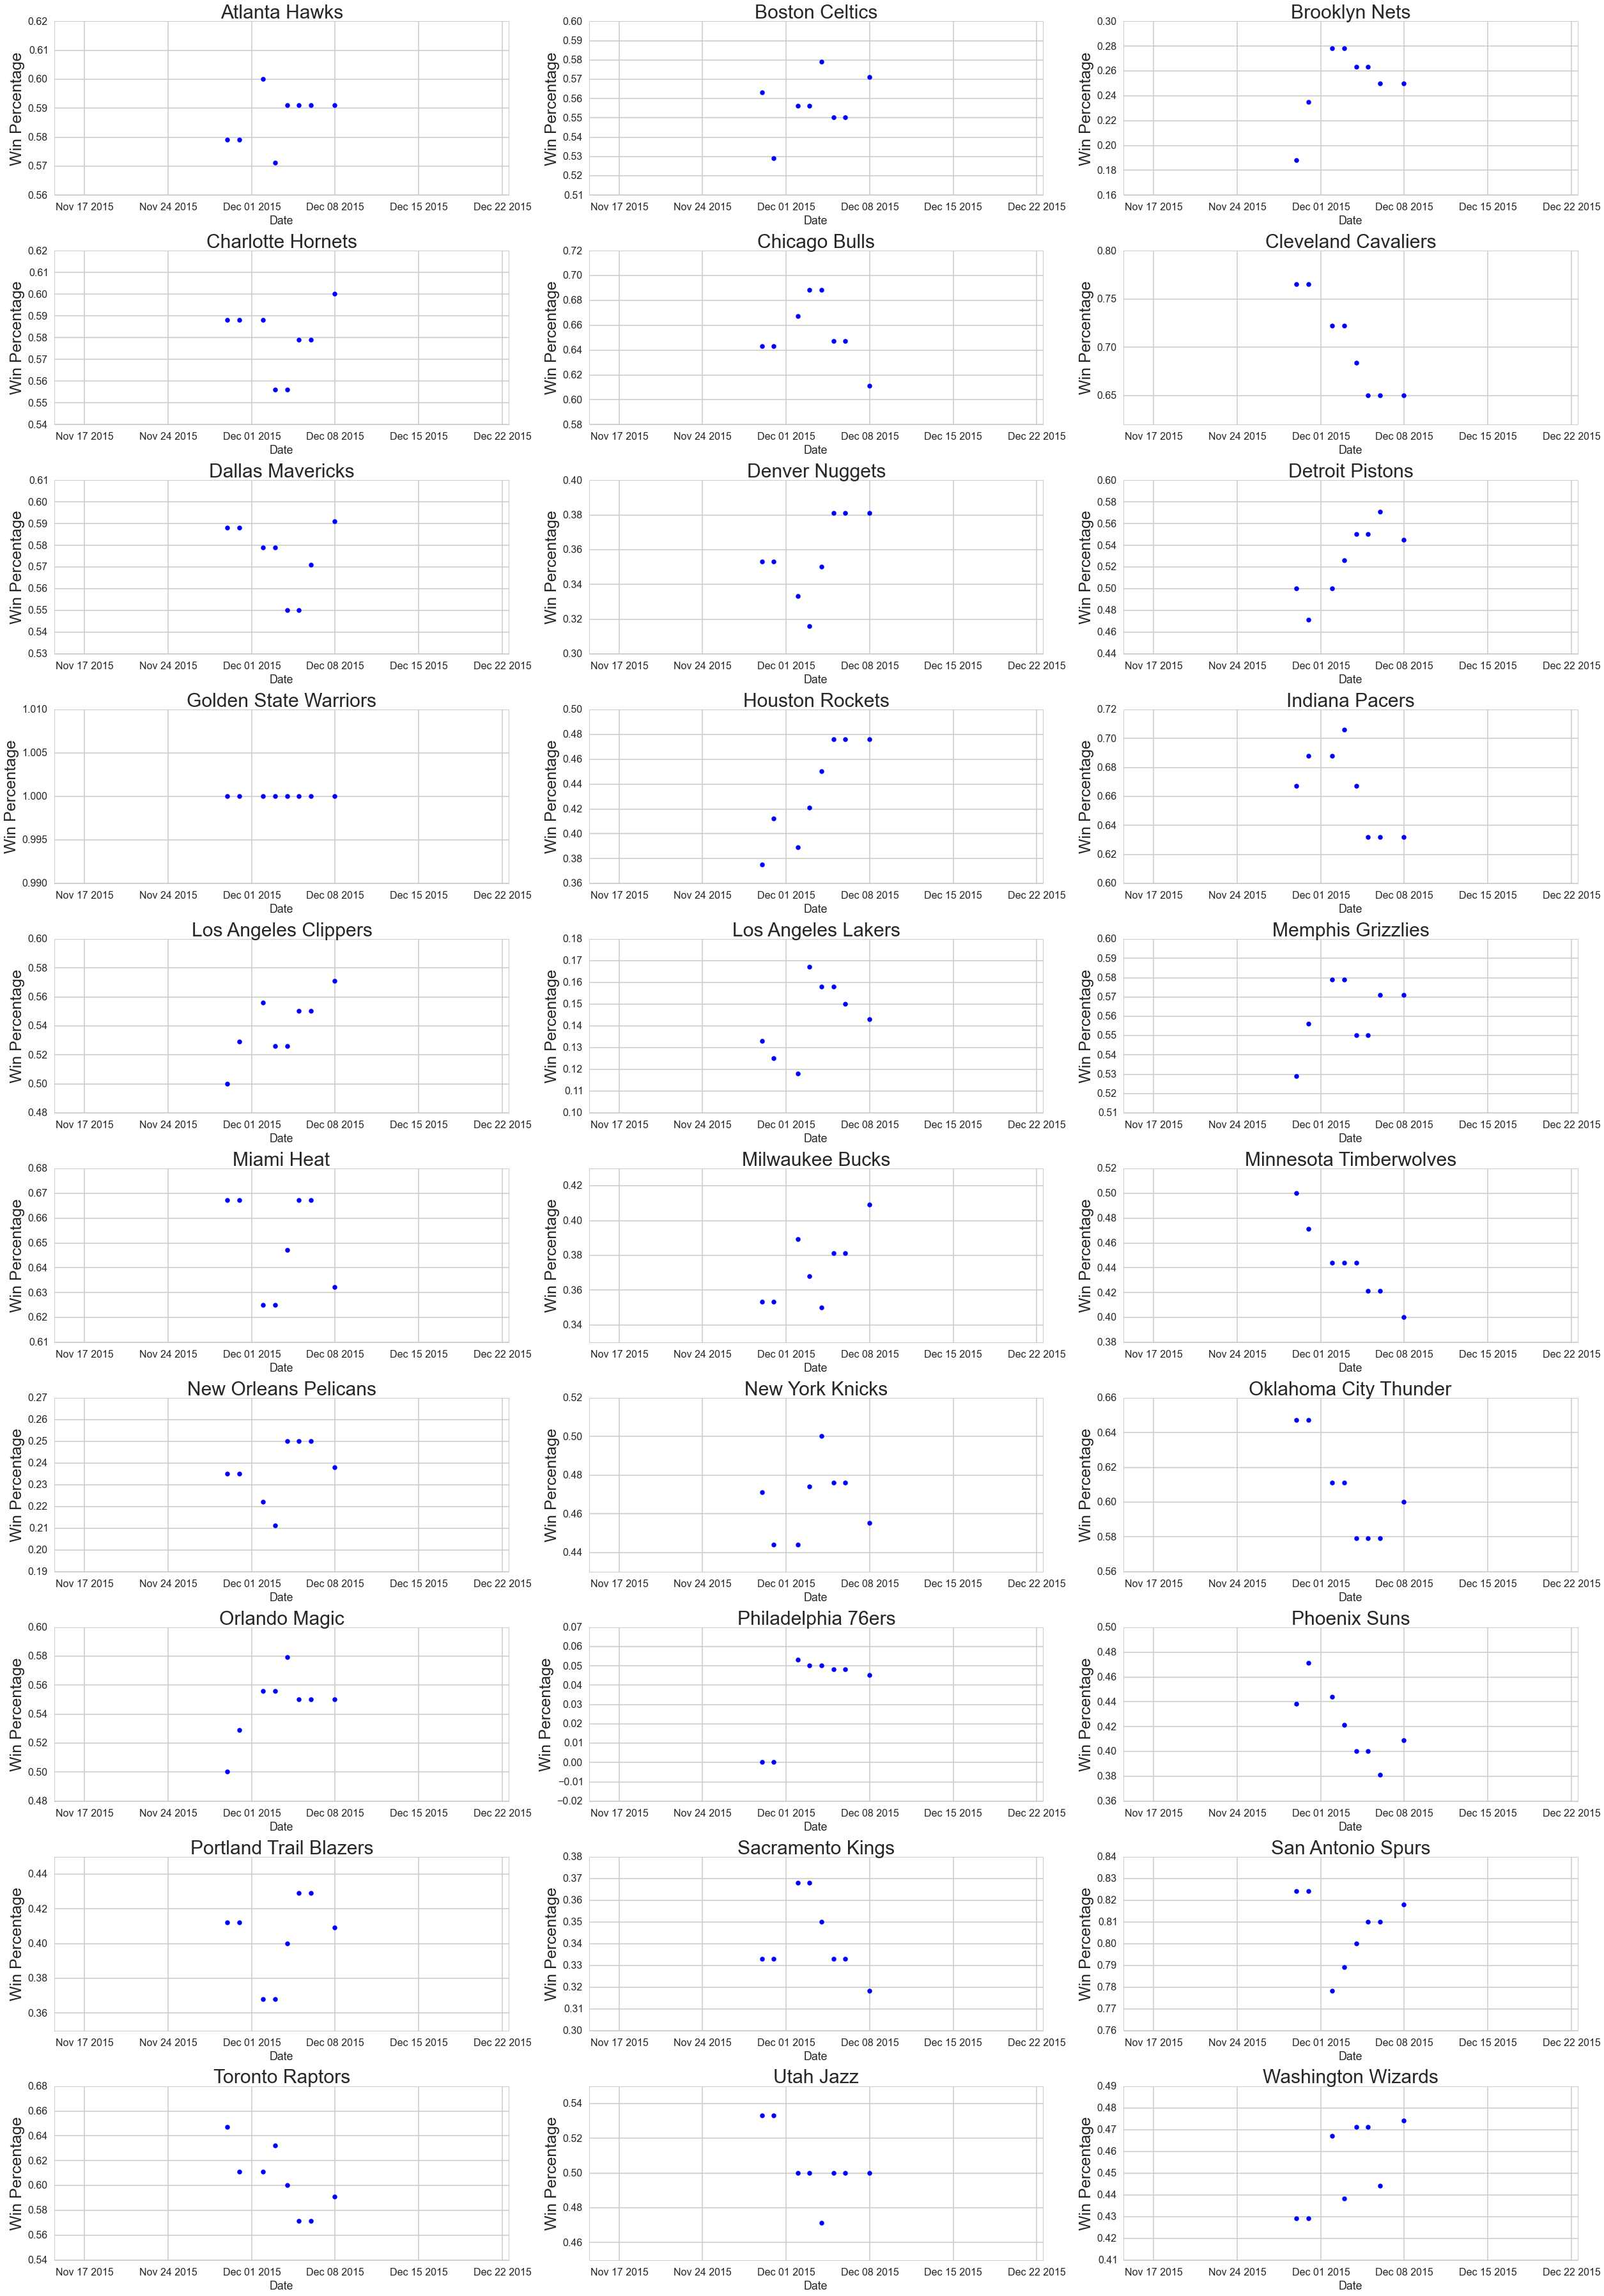

In [141]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(35, 50), tight_layout=True)

for ax, team in zip(axes.ravel(), result.groupby('Teams')):
    #establish a figure
    plt.figure()
    ax.scatter(team[1]['Date'].values, team[1]['PCT'].values, alpha=1, color='b', lw=3)
    ax.set_title(team[0],size=30)
    ax.set_xlabel('Date')
    ax.set_ylabel('Win Percentage',size=25)
    plt.close()

###2. Winning Streak By Team

Winning Streak is an interesting variable to look at. Even if a team has not played well so far in this season, if they win three games in a row, the ticket price might go up. Thus, we decided to explore winning streak as one of the candidates for our explanatory variables.

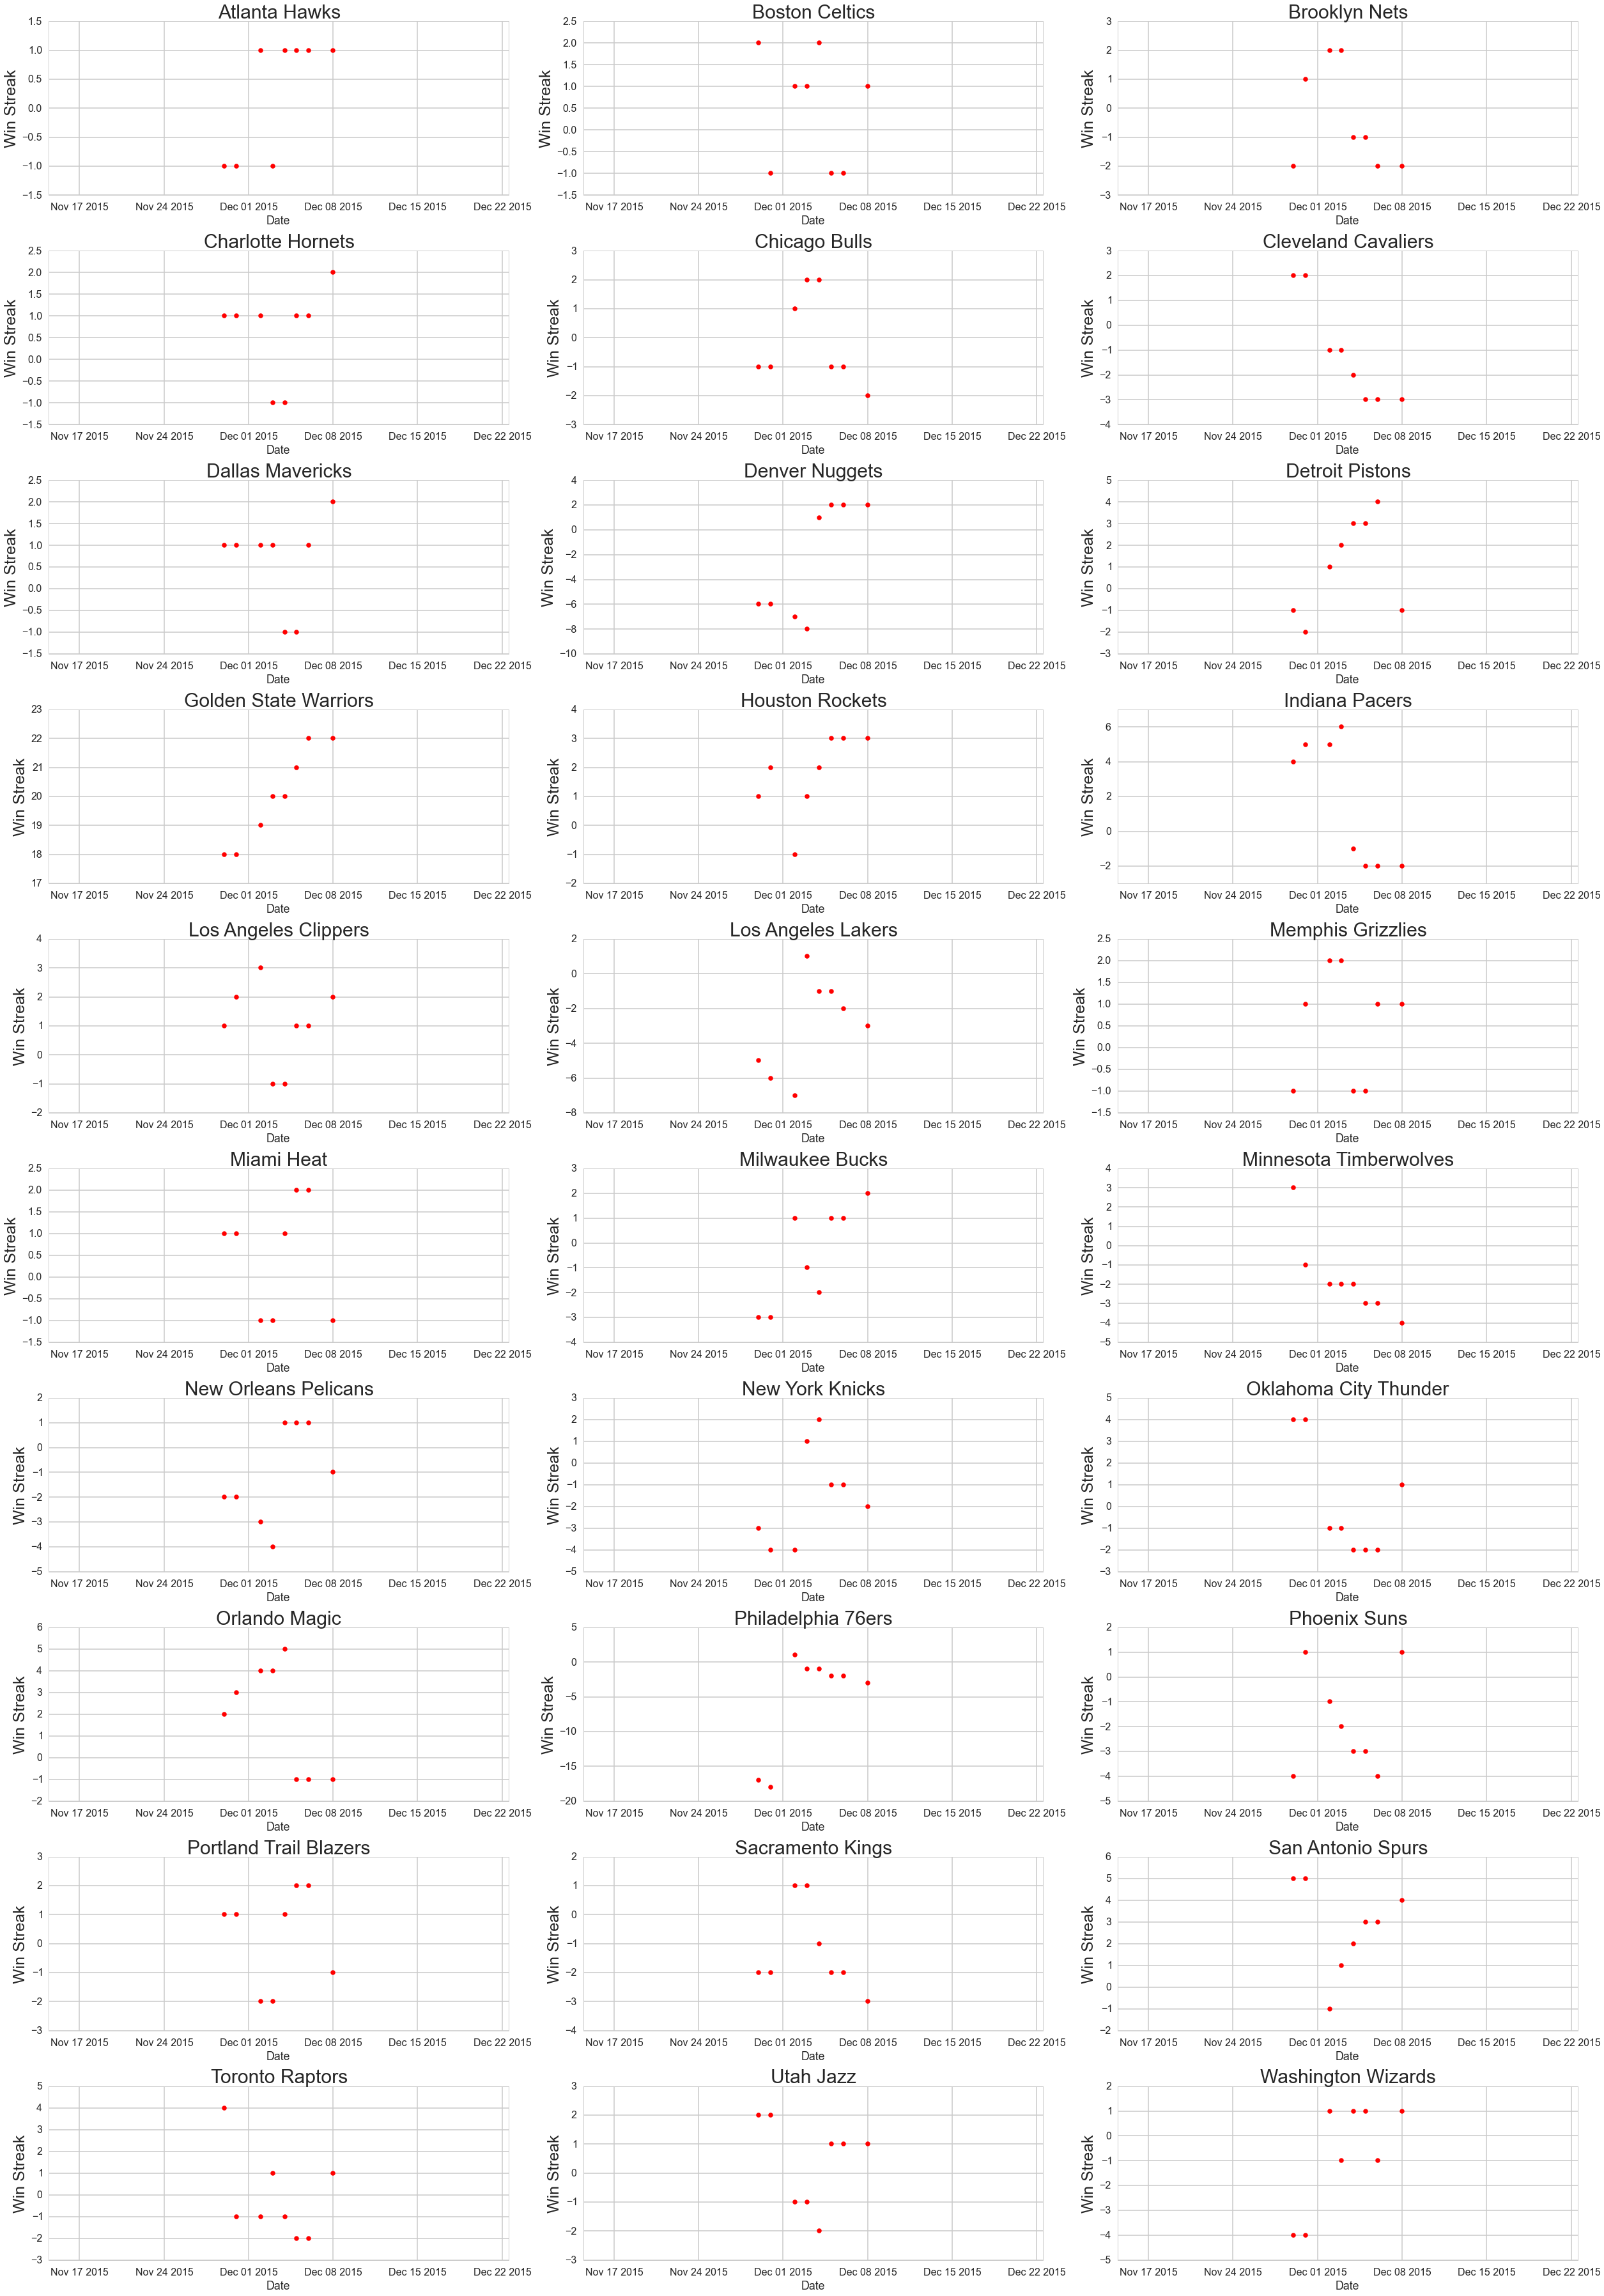

In [142]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(35, 50), tight_layout=True)

for ax, team in zip(axes.ravel(), result.groupby('Teams')):
    plt.figure()
    ax.scatter(team[1]['Date'].values, team[1]['STRK'].values, alpha=1, color='r', lw=3)
    ax.set_title(team[0],size=30)
    ax.set_xlabel('Date')
    ax.set_ylabel('Win Streak',size=25)
    plt.close()

Most of the case, it changes around 0. However, there is an extremely good team, Golden State Warriors. They are winning 22 games in a row.

We examine streaks over time by plotting streaks on each day.

###3. Winning Streak Over Time

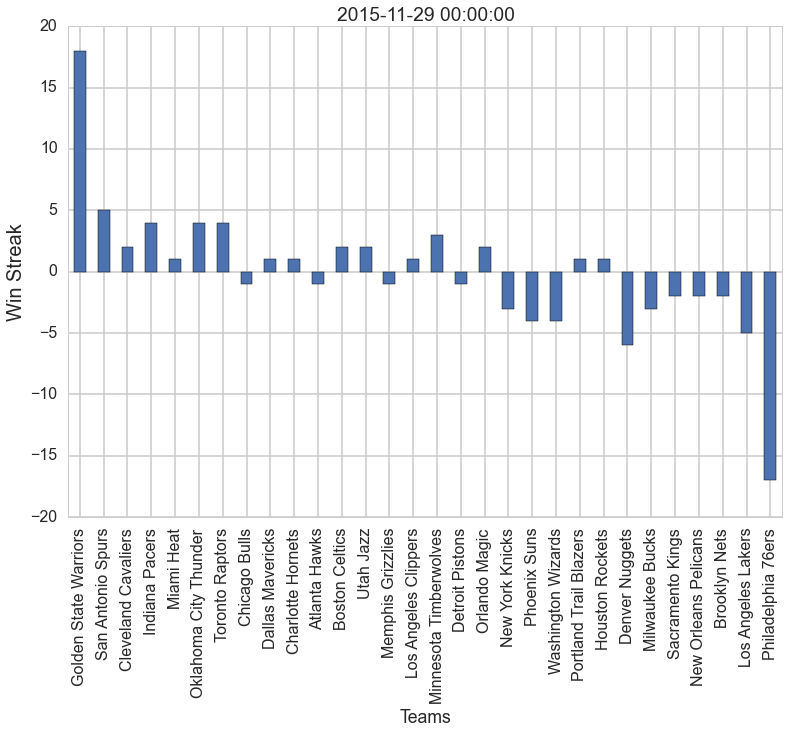

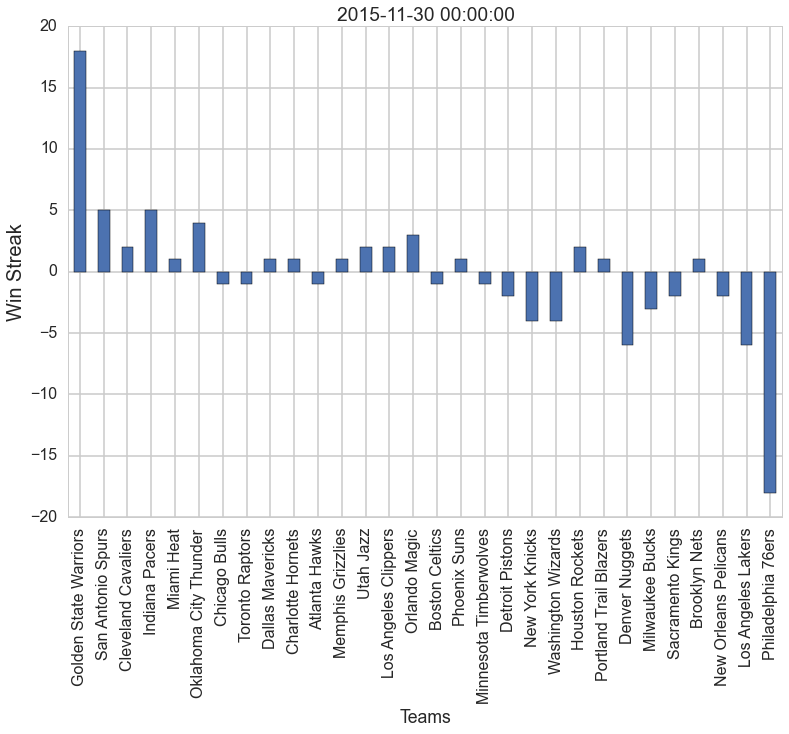

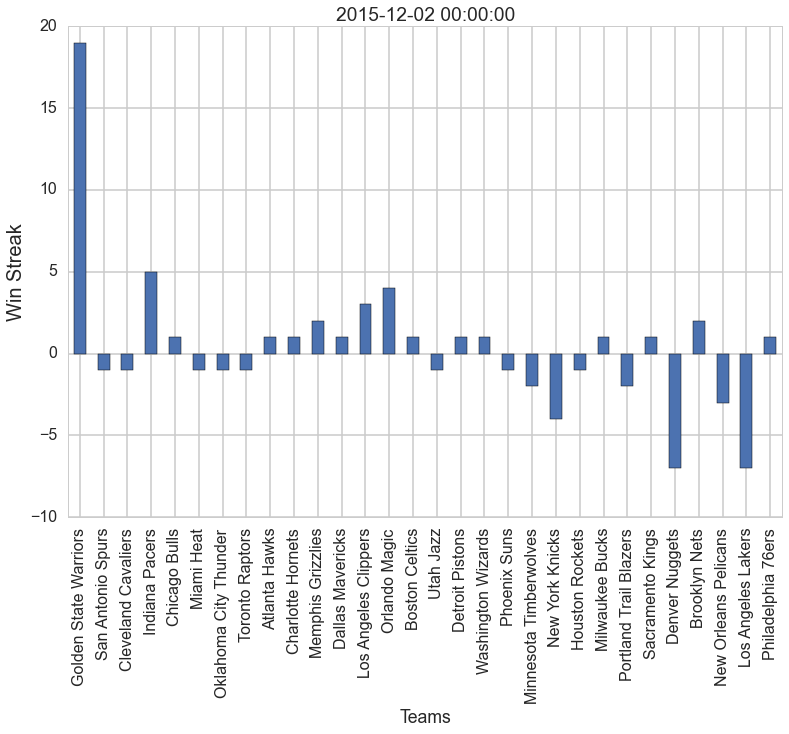

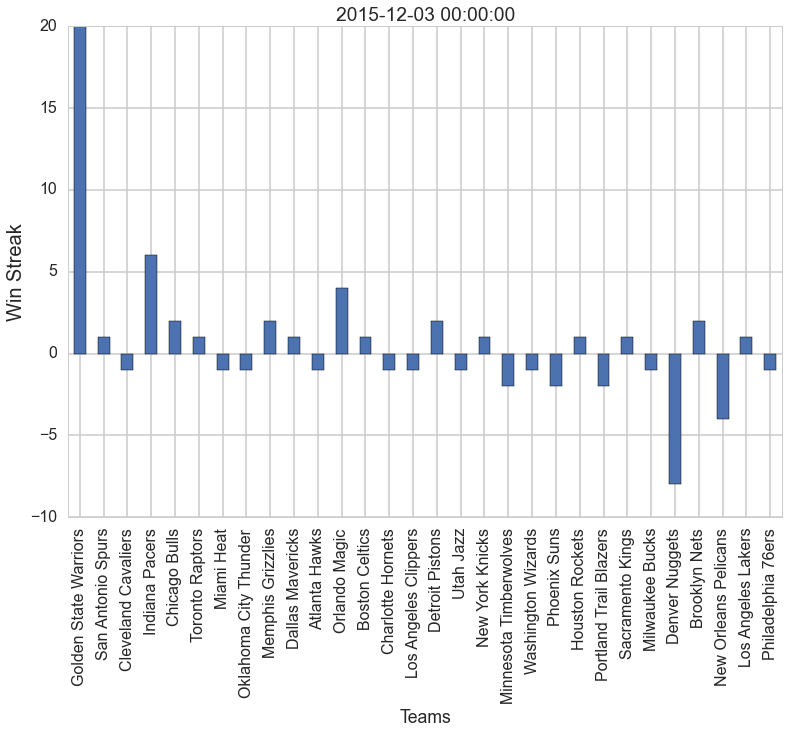

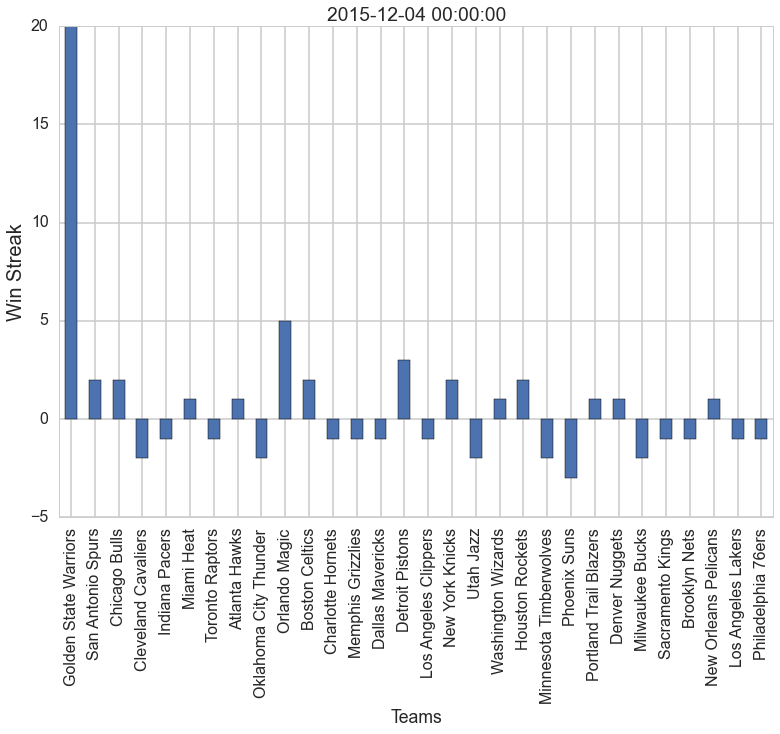

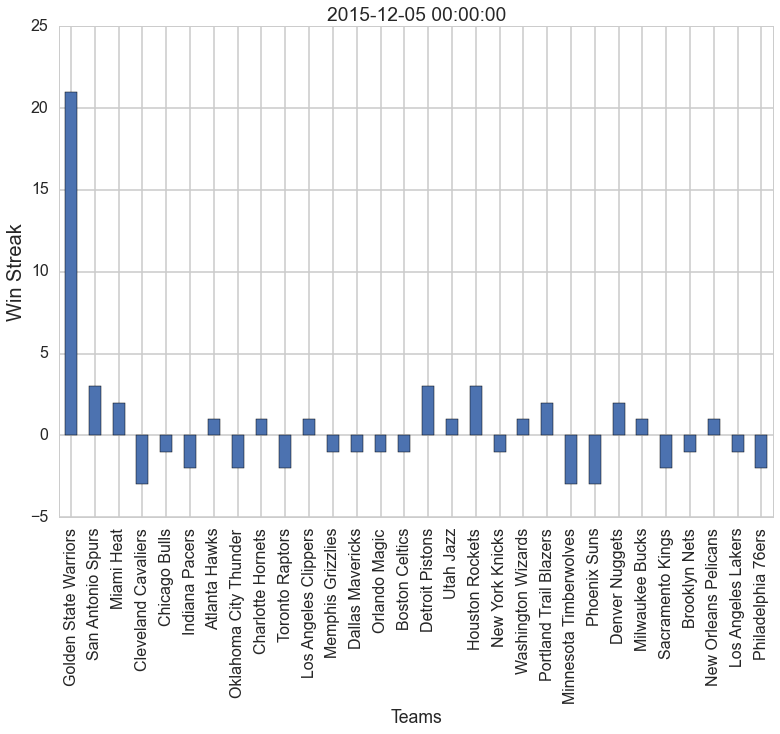

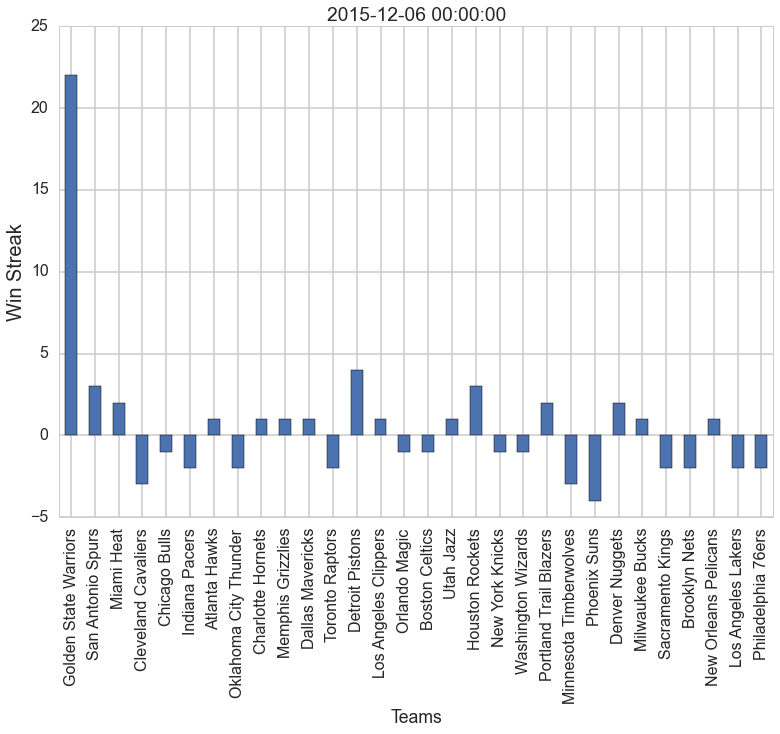

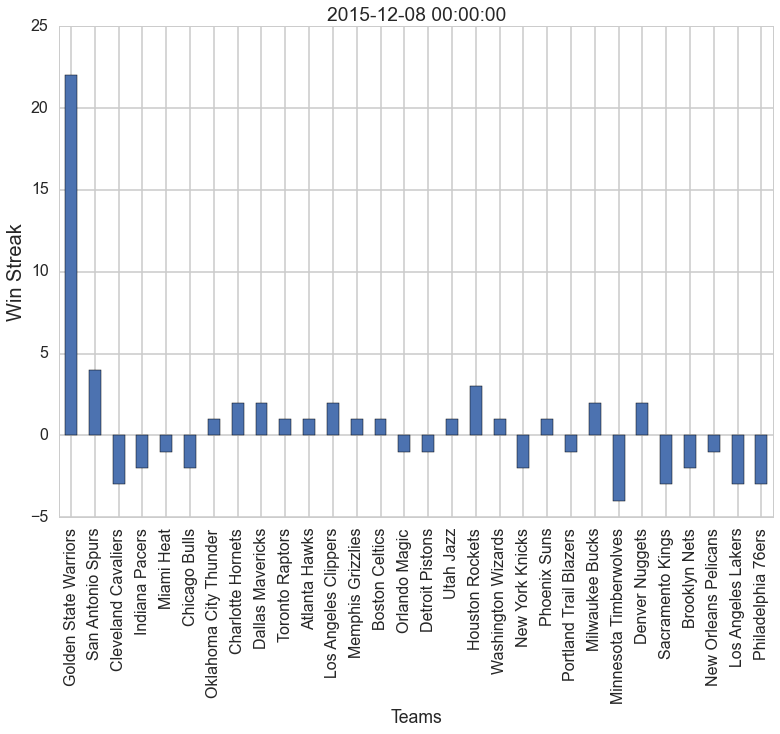

In [143]:
for day in result.groupby('Date'):
    plt.figure()
    lol=day[1].set_index('Teams')
    lol['STRK'].plot(kind='bar')
    plt.title(day[0])
    plt.xlabel('Teams')
    plt.ylabel('Win Streak',size=20)
    plt.show()

These graphs make it easier to compare teams. Most of the teams are +-5 winning streaks. Golden State Warriors is winning 22 games in a row. Philadelphia 76ers was losing almost 20 games in a row until they won the game against Lakers on December 1st.

###4. Winning Percentage Over Time

Next we would like to see how the winning percentage changes over time. 
We made a graph for each team on each date.

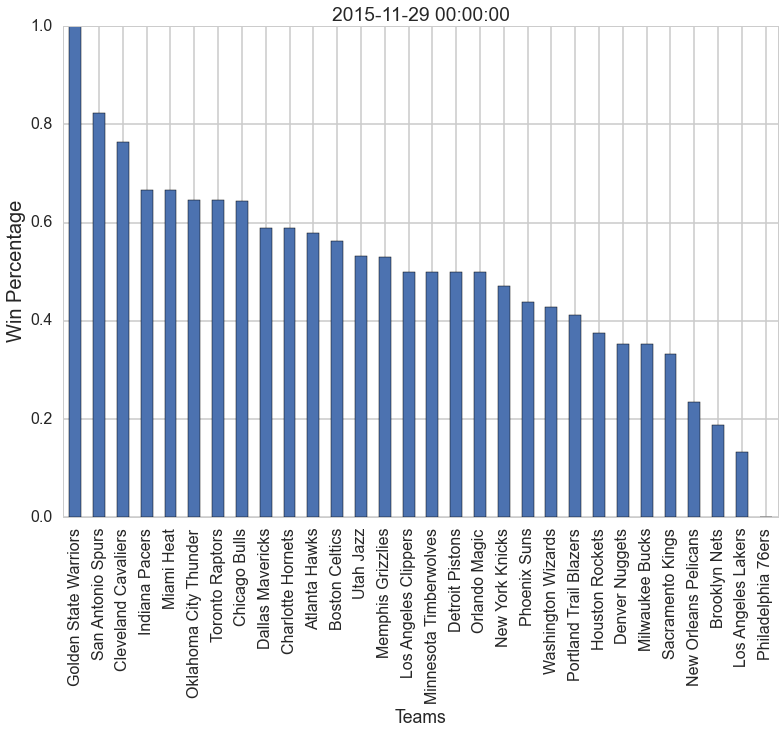

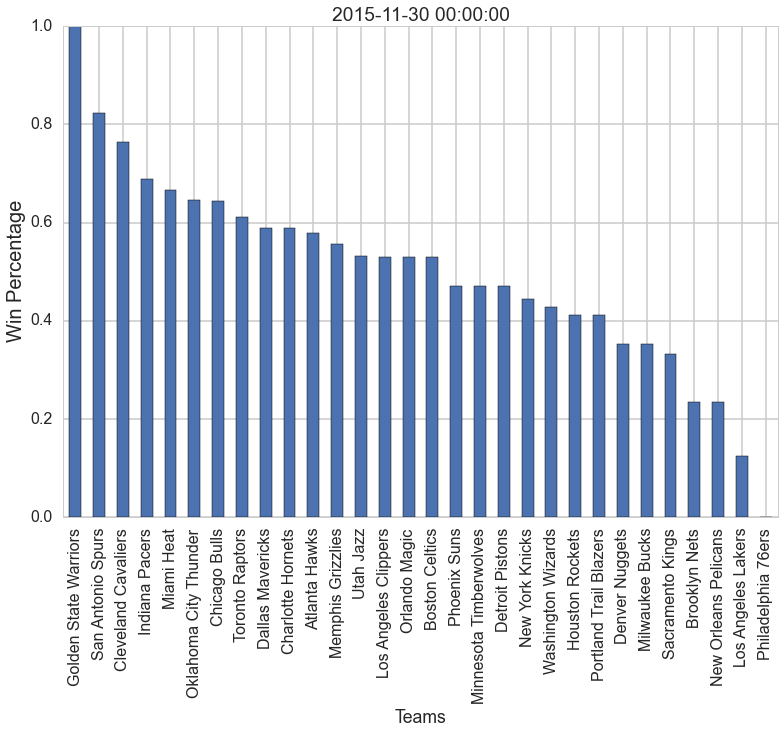

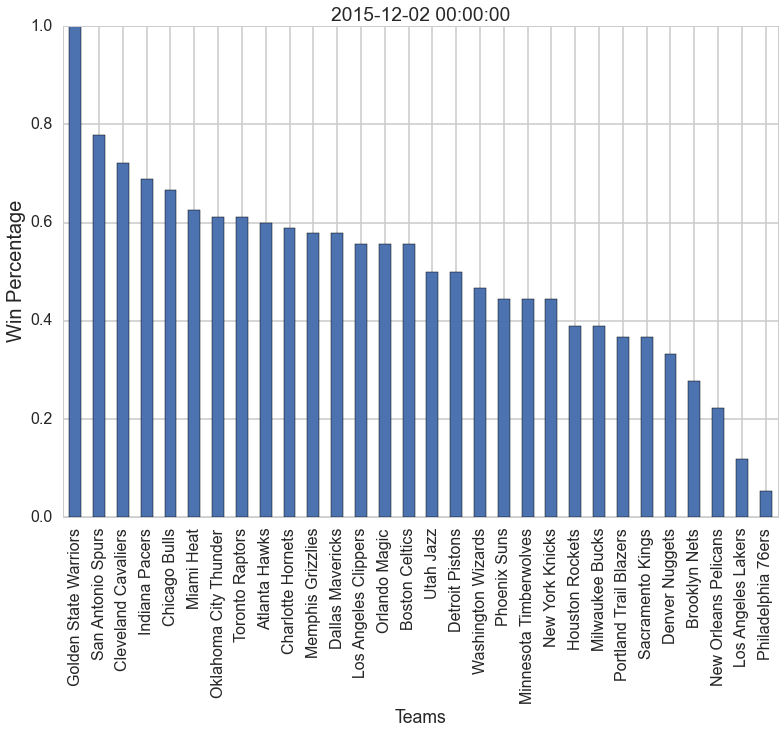

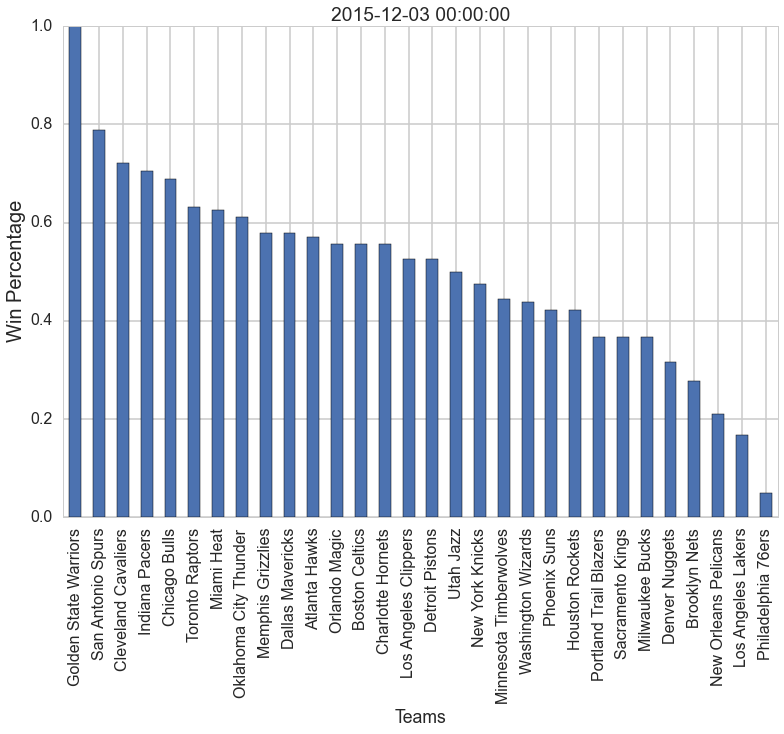

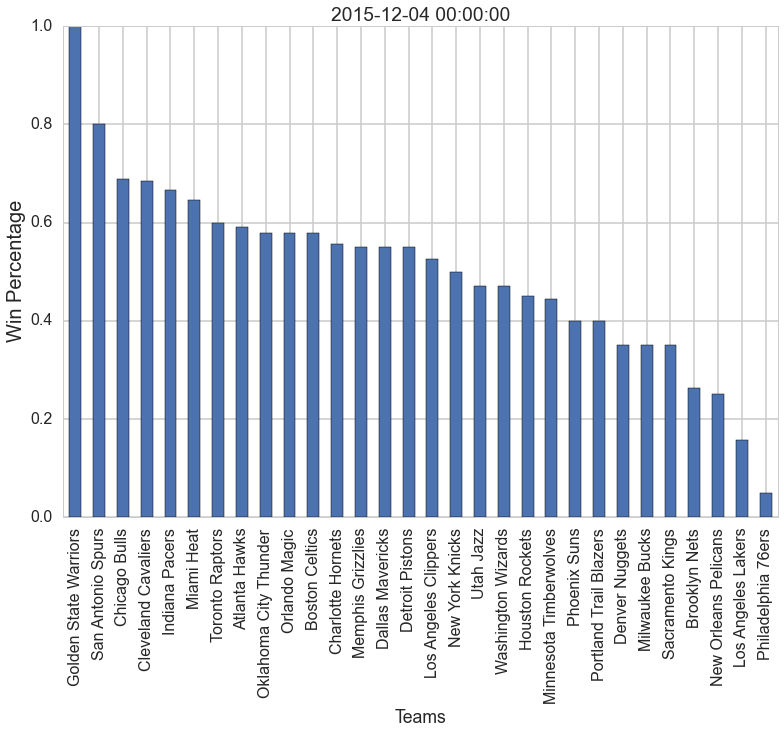

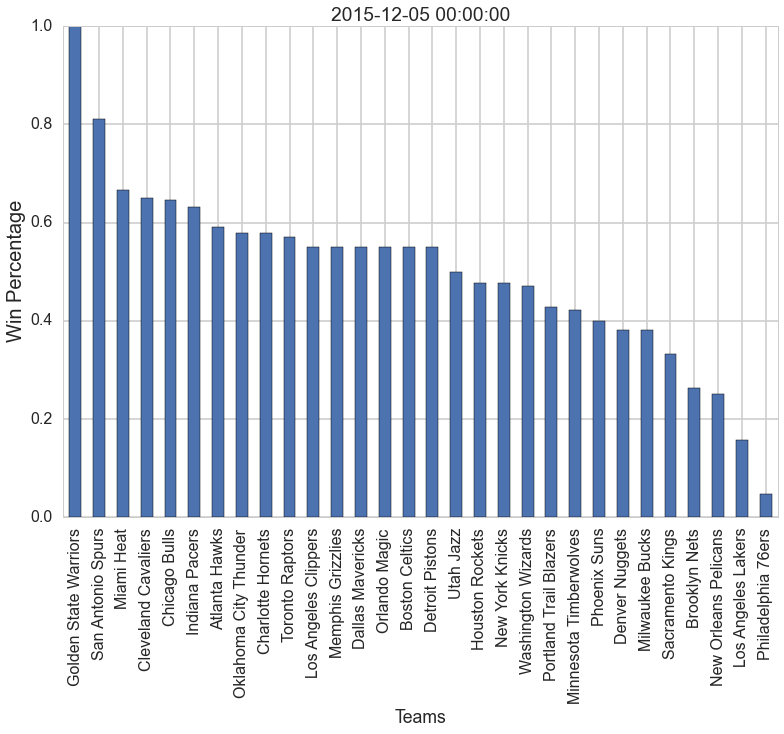

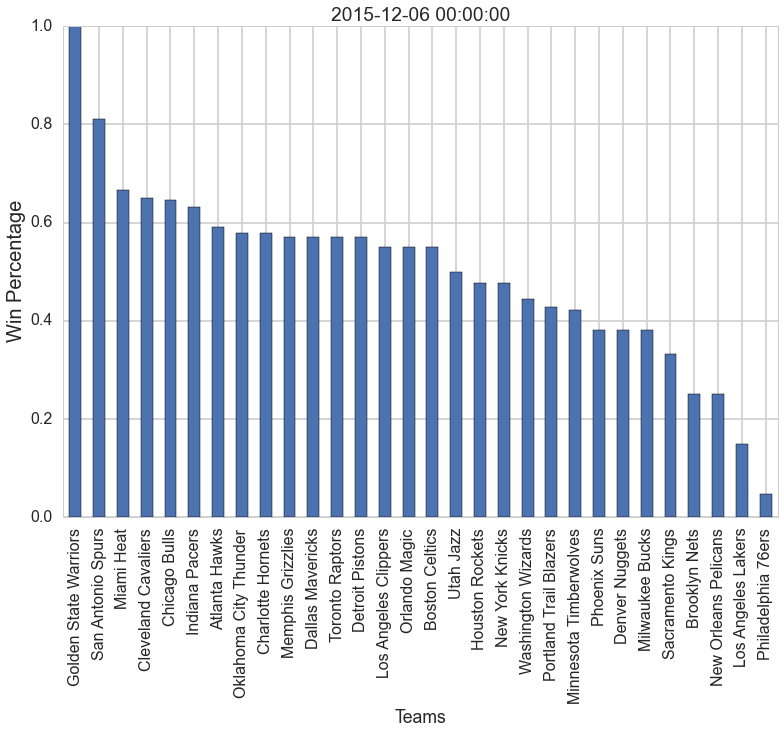

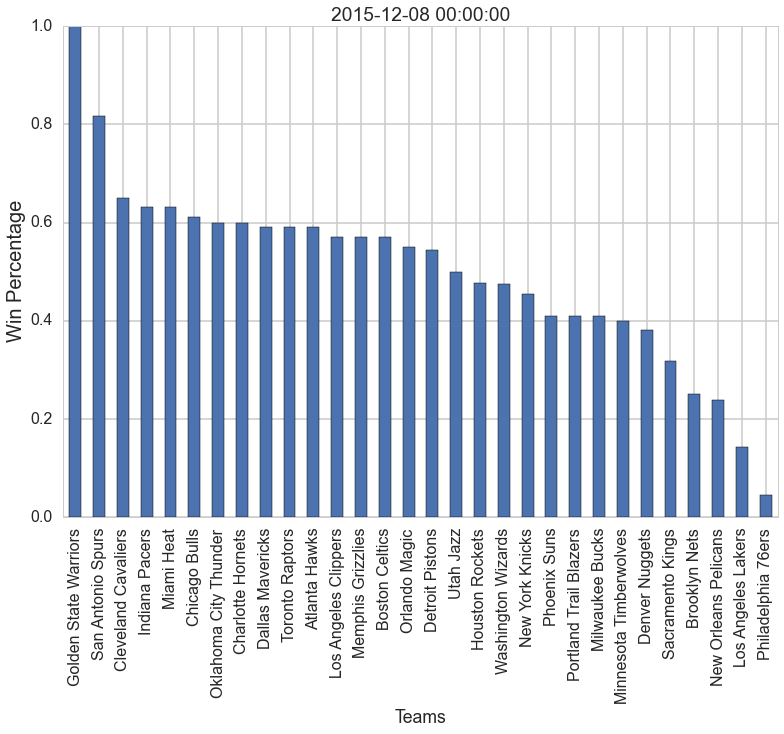

In [144]:
for day in result.groupby('Date'):
    plt.figure()
    lol=day[1].set_index('Teams')
    lol['PCT'].plot(kind='bar')
    plt.title(day[0])
    plt.xlabel('Teams')
    plt.ylabel('Win Percentage',size=20)
    plt.show()

###5. Winning Percentage Over Time in One Chart

The following graph shows the change of winning percentage of each team in this period.

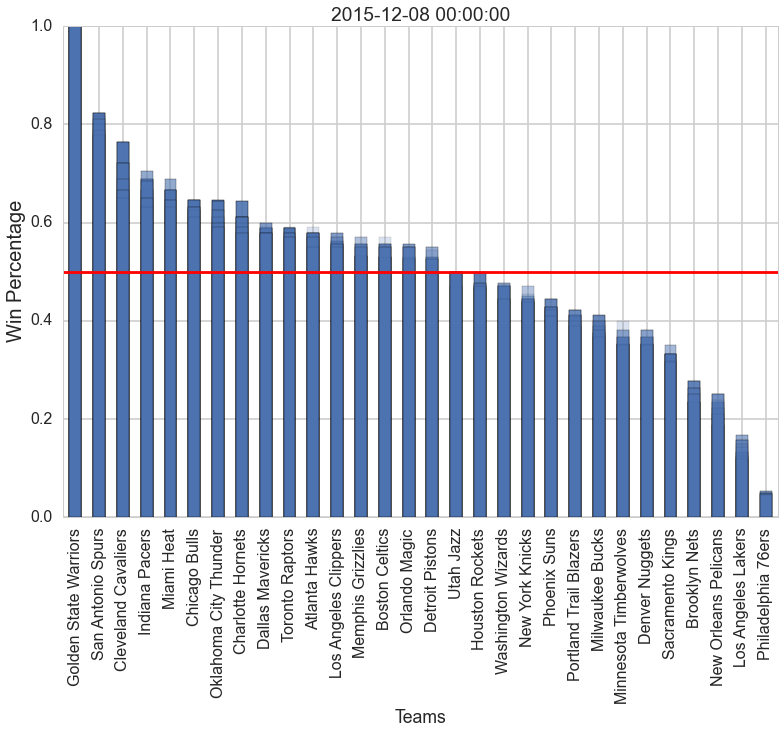

In [145]:
#scatter plot of ticket price vs. winning record here
plt.figure()
count=0.9

for day in result.groupby('Date'):
    lol=day[1].set_index('Teams')
    lol['PCT'].plot(kind='bar', alpha=count)
    plt.title(day[0])
    plt.xlabel('Teams')
    plt.ylabel('Win Percentage',size=20)
    count-=0.1
plt.axhline(y=0.5, color='r')
plt.show()

###6. Winning Streaks Over Time in One Chart

The following graph shows the change of a winning streak of each team in this period. Most of the teams winning streaks are +-5. Golden State is exceptionally good and Philadelphia 76ers is extremely bad.

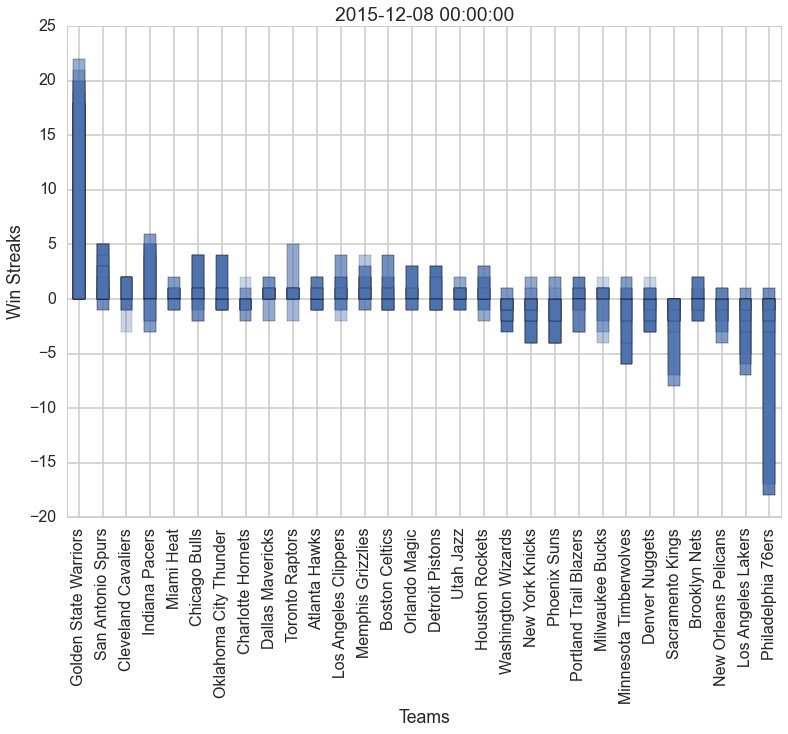

In [146]:
plt.figure()
count=1
for day in result.groupby('Date'):
    lol=day[1].set_index('Teams')
    lol['STRK'].plot(kind='bar', alpha=count)
    plt.title(day[0])
    plt.xlabel('Teams')
    plt.ylabel('Win Streaks')
    count-=0.10
plt.show()

####We have decided to use winning streaks and winning percentage as two of our explanatory variables.

##IV.ii Salary

We get salary of top 40 players in NBA and then aggregate the data by teams. Count is the number of top 40 highly-paid players on each team. The total salary is the sum of salary of these highly-paid players in each team.

In [147]:
NBAsalaryplayers=pd.read_csv("Salary/NBA" + "2015-11-29" + ".csv", index_col=0)
NBAsalary1=NBAsalaryplayers.groupby('TEAM').sum()
NBAsalary1.drop('RK', axis=1, inplace=True)
NBAsalary2=NBAsalaryplayers.groupby('TEAM').count()
NBAsalary2.drop(NBAsalary2.columns[[0,2]], axis=1, inplace=True)
NBAsalary=pd.concat([NBAsalary1, NBAsalary2], axis=1)
NBAsalary.columns = ['TotalSalary', 'Count']
NBAsalary.sort(columns='TotalSalary', ascending=False)

TotalSalary  Count
TEAM                                      
Brooklyn Nets              58654317      3
Oklahoma City Thunder      47064686      3
Dallas Mavericks           42455978      3
Golden State Warriors      40274517      3
Los Angeles Clippers       37743176      2
Cleveland Cavaliers        36363463      2
Houston Rockets            36165115      2
Miami Heat                 35644400      2
Sacramento Kings           34063326      2
Memphis Grizzlies          32329688      2
Chicago Bulls              31562876      2
Indiana Pacers             30836228      2
Washington Wizards         27746000      2
Los Angeles Lakers         23500000      1
New York Knicks            22458401      1
Portland Trail Blazers     16006000      1
New Orleans Pelicans       14898938      1
Charlotte Hornets          13500000      1
Phoenix Suns               13000000      1
Utah Jazz                  12950000      1
San Antonio Spurs          12500000      1
Minnesota Timberwolves     12100000      1
Toronto Raptors            12000000      1

###1. Salary of Stars on Each Team

Brooklyn Nets pays most to top players in NBA. This is interesting because Brooklyn is one of the worst-performance teams in NBA. Philadelphia 76ers has none of the top 40 players and this might be one of the reasons why they are not playing well. Golden State Warriors is the fourth in this rank. 

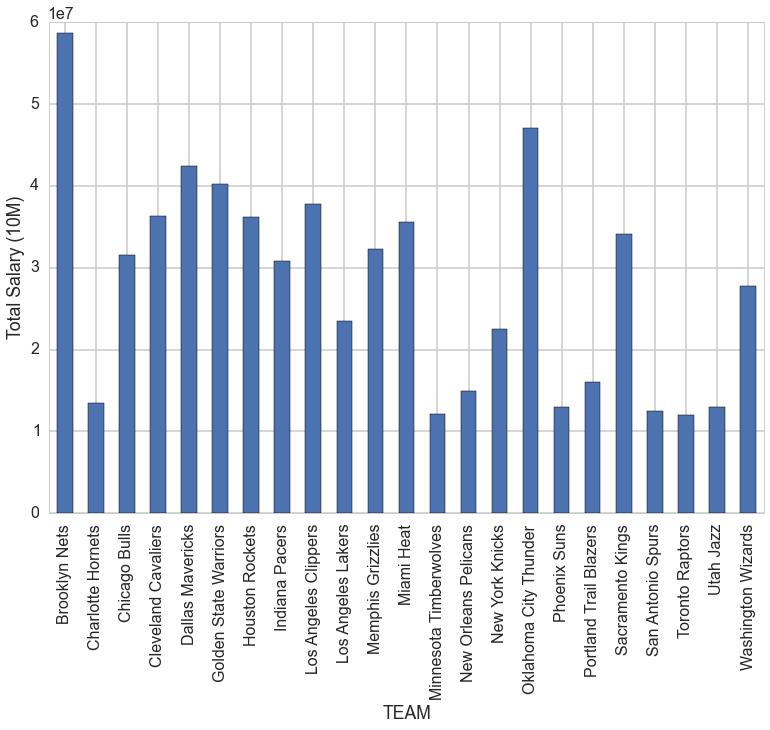

In [148]:
NBAsalary['TotalSalary'].plot(kind='bar')
plt.ylabel('Total Salary (10M)')
plt.show()

###2. Number of Stars on Each Team

Next we look at number of star players on each team.

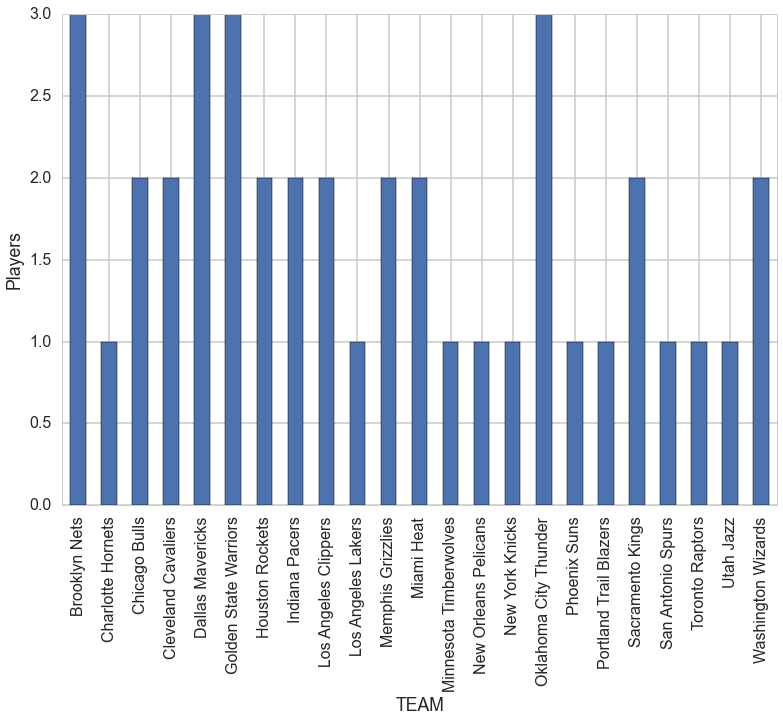

In [149]:
NBAsalary['Count'].plot(kind='bar')
plt.ylabel('Players')
plt.show()

Dallas Mavericks, Brooklyn Nets, Golden State Warriors and Oklahoma City Thunder have 3 out of top 40 players in NBA. 
Dallas Mavericks, Golden State Warriors and Oklahoma City Thunder are relatively high-ranked teams, but Brooklyn Nets is one of the worst teams in NBA. 

This tells that getting star players is important but it does not gurantee the success in NBA.

####We decided to use salary and number of stars in our model

## IV.iii Attendance

In [150]:
attendance=pd.read_csv("Attendance/NBA" + "2015-12-08" + ".csv", index_col=0)

In [151]:
attendance.columns = ['RK','TEAM','HomeGames', 'HomeTotal','HomeAVG','HomePCT','AwayGames','AwayAVG','AwayPCT','TotalGames', 'TotalAVG','TotalPCT']
attendance.sort('TotalPCT', ascending=False).head(2)

RK     TEAM  HomeGames  HomeTotal  HomeAVG  HomePCT  AwayGames  AwayAVG  AwayPCT  TotalGames  TotalAVG  TotalPCT
10  11   Lakers          7     132979    18997     99.7         14    19417     99.6          21     19277      99.6
12  13  Thunder         12     218436    18203    100.0          8    19104     99.0          20     18563      99.6

In [152]:
attendance

RK           TEAM  HomeGames  HomeTotal  HomeAVG  HomePCT  AwayGames  AwayAVG  AwayPCT  TotalGames  TotalAVG  TotalPCT
0    1          Bulls         10     217165    21716    103.8          8    17164     87.7          18     19693      96.9
1    2      Cavaliers         10     205620    20562    100.0         10    19188     98.1          20     19875      99.1
2    3      Mavericks          8     160894    20111    104.7         14    17641     93.6          22     18539      97.7
3    4        Raptors          9     179263    19918    100.6         13    17450     91.2          22     18460      95.1
4    5      NY Knicks         12     237744    19812    100.0         10    18735     97.7          22     19322      99.0
5    6           Heat         14     274999    19642    100.2          5    16840     84.2          19     18905      95.9
6    7       Warriors         10     195960    19596    100.0         12    18394     98.7          22     18940      99.3
7    8           Jazz          8     156588    19573     98.3         10    17026     87.0          18     18158      92.1
8    9  Trail Blazers         10     192882    19288     92.7         12    16869     89.2          22     17968      90.9
9   10       Clippers         14     267955    19139    100.4          7    16882     88.3          21     18387      96.4
10  11         Lakers          7     132979    18997     99.7         14    19417     99.6          21     19277      99.6
11  12          Spurs         11     202598    18418     99.1         11    17917     93.5          22     18167      96.3
12  13        Thunder         12     218436    18203    100.0          8    19104     99.0          20     18563      99.6
13  14        Wizards         10     178561    17856     88.1          9    17901     92.1          19     17877      89.9
14  15        Celtics         10     178459    17845     95.8         11    16680     91.1          21     17235      93.3
15  16        Rockets         13     229171    17628     97.7          8    18072     93.7          21     17797      96.1
16  17          Kings         12     208151    17345    100.2         10    16766     89.0          22     17082      94.9
17  18          Magic         10     173349    17334     92.0         10    17146     88.5          20     17240      90.2
18  19           Suns         10     173034    17303     93.9         12    16976     87.7          22     17125      90.5
19  20      Grizzlies         11     187417    17037     94.0         10    17765     94.5          21     17384      94.3
20  21       Pelicans         10     169681    16968     98.7         11    18691     97.2          21     17870      97.9
21  22        Hornets         12     197320    16443     86.2          8    19106     97.3          20     17508      90.7
22  23        Pistons         10     163239    16323     73.9         12    16874     89.4          22     16624      81.8
23  24         Pacers          8     128716    16089     88.6         11    17868     88.8          19     17119      88.7
24  25          Hawks         12     191705    15975     85.3         10    17541     92.8          22     16687      88.7
25  26          76ers         10     149007    14900     73.3         12    17271     91.2          22     16193      82.7
26  27           Nets          8     118489    14811     81.8         12    17463     93.0          20     16402      88.6
27  28          Bucks         11     158017    14365     76.7         11    16427     84.3          22     15396      80.6
28  29   Timberwolves         11     151115    13737     71.0          9    17720     93.3          20     15529      80.9
29  30        Nuggets          9     122566    13618     71.1         12    17790     93.6          21     16002      83.9

###1. Number of Audience 

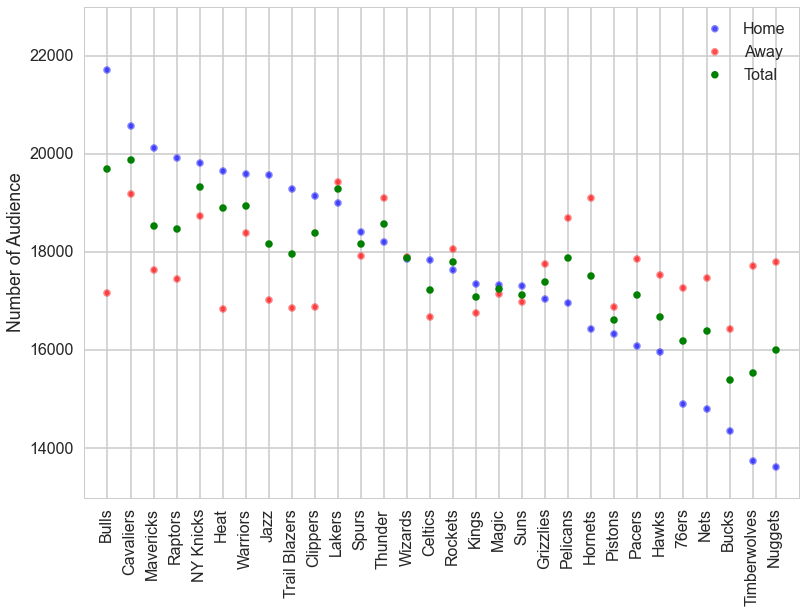

In [153]:
plt.figure()
plt.scatter(attendance.set_index('TEAM')['RK'], attendance.set_index('TEAM')['HomeAVG'], alpha=0.5, color='b', lw=3, label='Home')
plt.scatter(attendance.set_index('TEAM')['RK'], attendance.set_index('TEAM')['AwayAVG'], alpha=0.5, color='r', lw=3, label='Away')
plt.scatter(attendance.set_index('TEAM')['RK'], attendance.set_index('TEAM')['TotalAVG'], alpha=1, color='g', lw=3, label='Total')
plt.xticks(attendance.set_index('TEAM')['RK'], attendance['TEAM'], rotation='vertical')
plt.ylabel('Number of Audience')
plt.legend(loc='best')
plt.xlim([0, 31])
 
plt.show()

The number of audience decreases as the team performs worse. Good-performance teams have more audience than bad-performance teams. However, some arenas have more capacity than other arenas. In fact, the capacity of Bulls' arena is 20500 and the capacity of Golden State Warrior's arena is 19,596. In order to compare the audience of teams, we have to look at the ratio of average audience to the capacity.

###2. Ratio of Audience to Capacity

Most of the good-performance teams such as Golden State Warriors and Chicago Bulls have more than 95 percent of capacity as audience in home games.

Lower-ranked teams such as Pistons, 76ers, Timberwolves and Nuggets have less than 80 percent of capacity in home games.

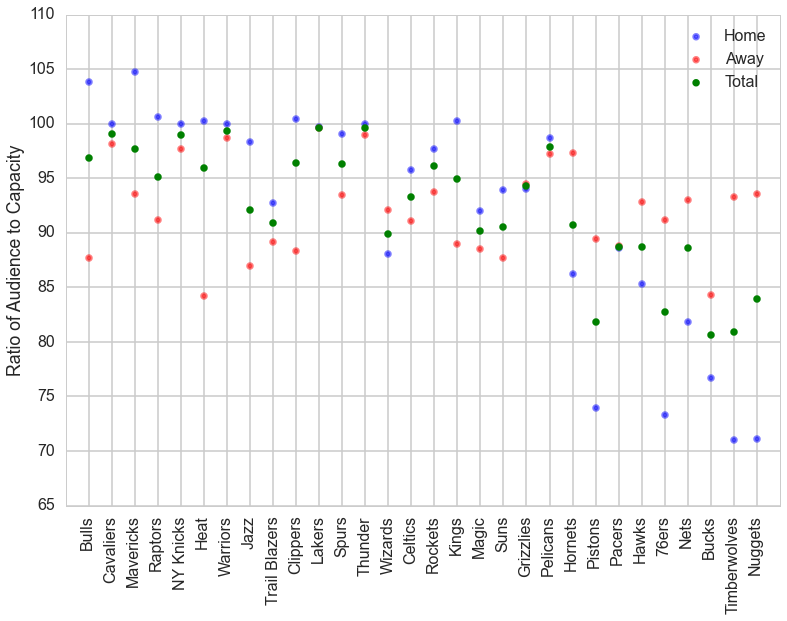

In [154]:
plt.figure()
plt.scatter(attendance.set_index('TEAM')['RK'], attendance.set_index('TEAM')['HomePCT'], alpha=0.5, color='b', lw=3, label='Home')
plt.scatter(attendance.set_index('TEAM')['RK'], attendance.set_index('TEAM')['AwayPCT'], alpha=0.5, color='r', lw=3, label='Away')
plt.scatter(attendance.set_index('TEAM')['RK'], attendance.set_index('TEAM')['TotalPCT'], alpha=1, color='g', lw=3, label='Total')
plt.xticks(attendance.set_index('TEAM')['RK'], attendance['TEAM'], rotation='vertical')
plt.ylabel('Ratio of Audience to Capacity')
plt.legend(loc='best')
plt.xlim([0, 31])

plt.show()

##IV.iv Ticket Prices

In [155]:
#Get Data from Ticket_Data

a=pd.read_csv("Tickets_Data/basketballdf" + "2015-11-25" + ".csv", index_col=0)
b=pd.read_csv("Tickets_Data/basketballdf" + "2015-11-26" + ".csv", index_col=0)
c=pd.read_csv("Tickets_Data/basketballdf" + "2015-11-27" + ".csv", index_col=0)
d=pd.read_csv("Tickets_Data/basketballdf" + "2015-11-28" + ".csv", index_col=0)
e=pd.read_csv("Tickets_Data/basketballdf" + "2015-11-29" + ".csv", index_col=0)
f=pd.read_csv("Tickets_Data/basketballdf" + "2015-11-30" + ".csv", index_col=0)
g=pd.read_csv("Tickets_Data/basketballdf" + "2015-12-01" + ".csv", index_col=0)
h=pd.read_csv("Tickets_Data/basketballdf" + "2015-12-03" + ".csv", index_col=0)
i=pd.read_csv("Tickets_Data/basketballdf" + "2015-12-04" + ".csv", index_col=0)
j=pd.read_csv("Tickets_Data/basketballdf" + "2015-12-05" + ".csv", index_col=0)
k=pd.read_csv("Tickets_Data/basketballdf" + "2015-12-06" + ".csv", index_col=0)
frames = [a,b,c,d,e,f,g,h,i,j,k]
tickets = pd.concat(frames).reset_index(drop=True)
tickets.drop(tickets.columns[[0,6,7,10,11,17,18,19,21,22,29]], axis=1, inplace=True)
tickets['dateutc'] = tickets['dateutc'].astype('datetime64')
#delete
# index 0
# datetime local 6
# created_at 7
# country 10
# extended address 11
# announce date 17
# short title 18
# datetime utc 19
# datetime tbd 21
# visible until utc 22
# time utc 29

First, we show a histogram for lowest price good deal. The graph looks right skewed. The price of most tickets is less than 40 dollars

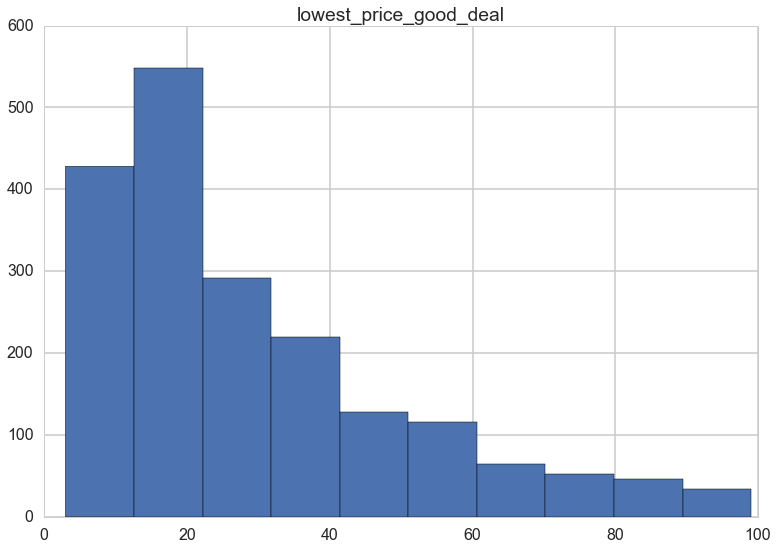

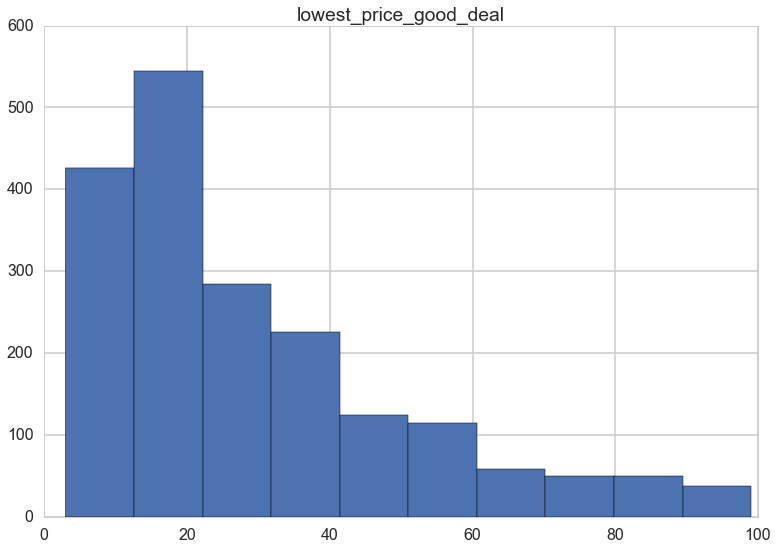

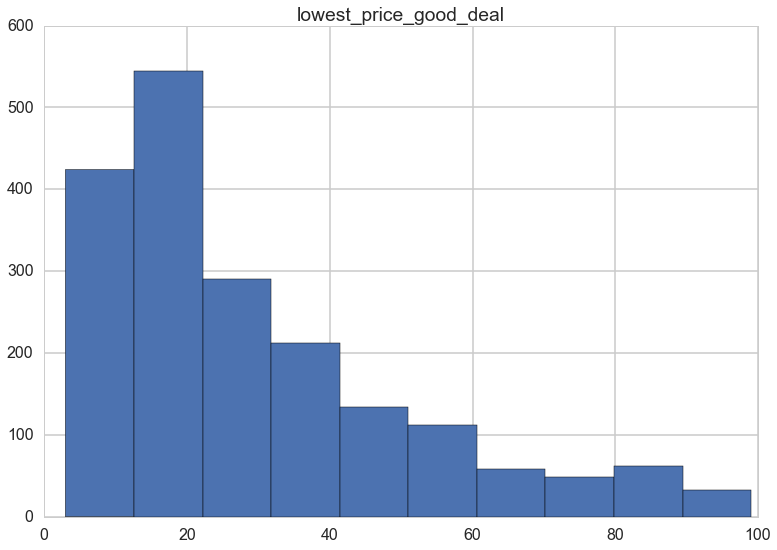

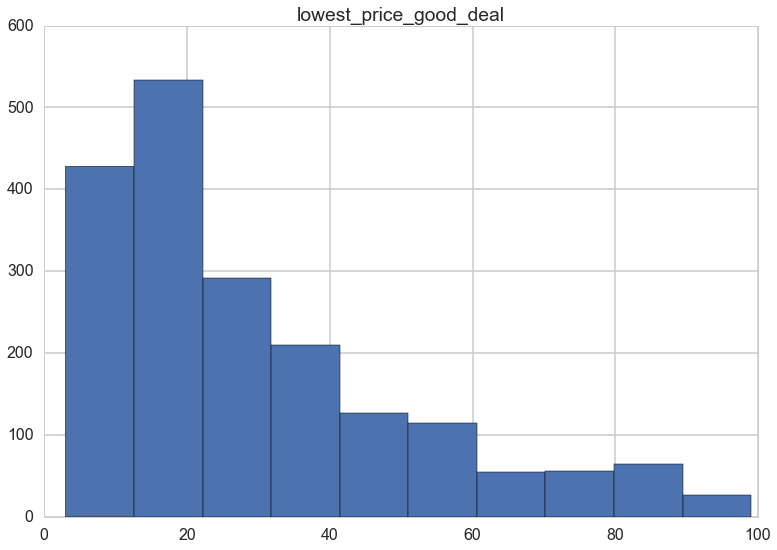

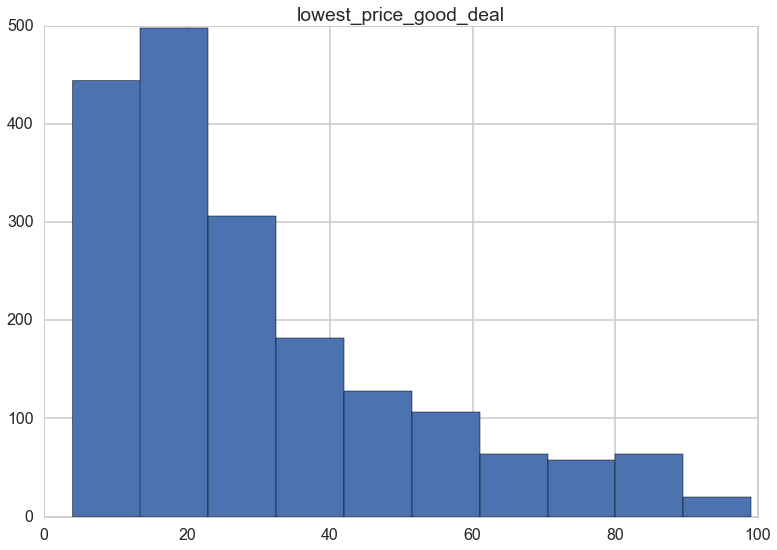

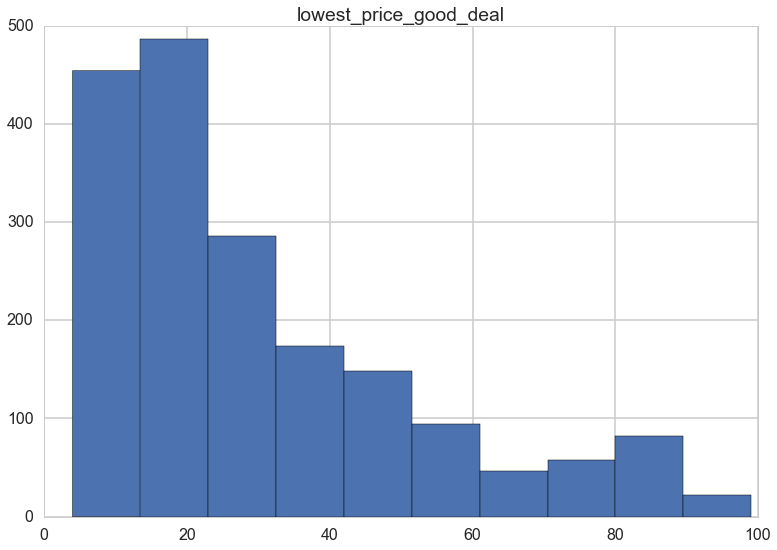

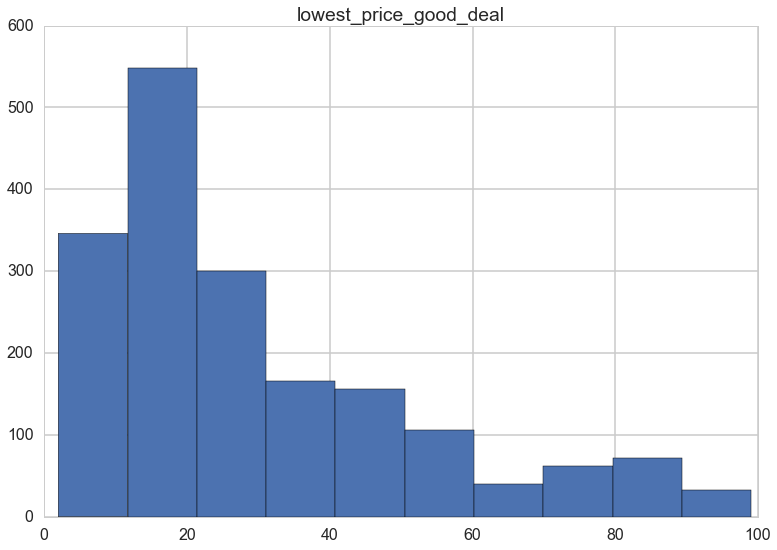

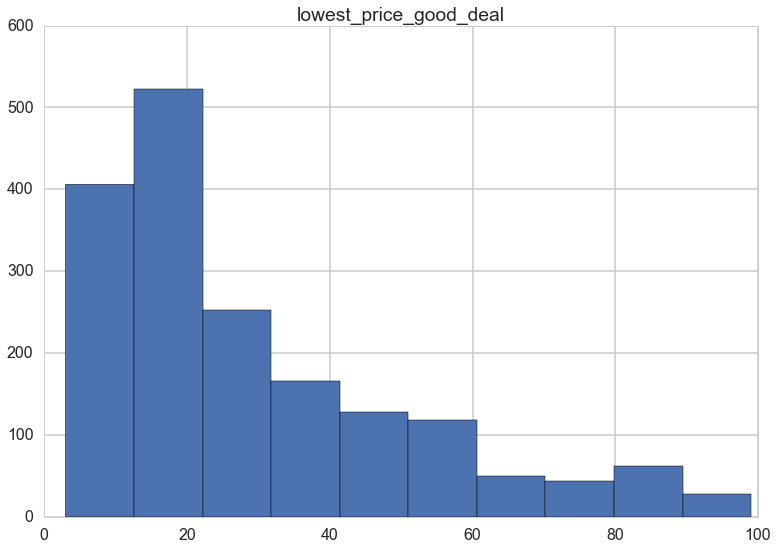

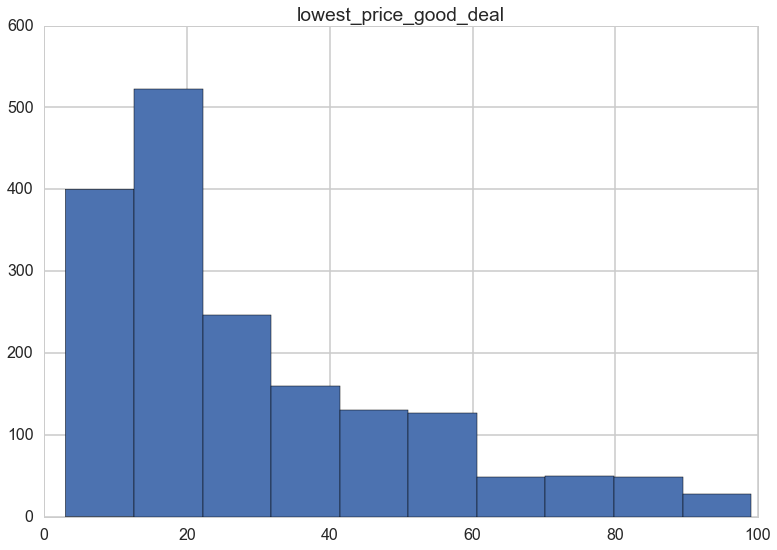

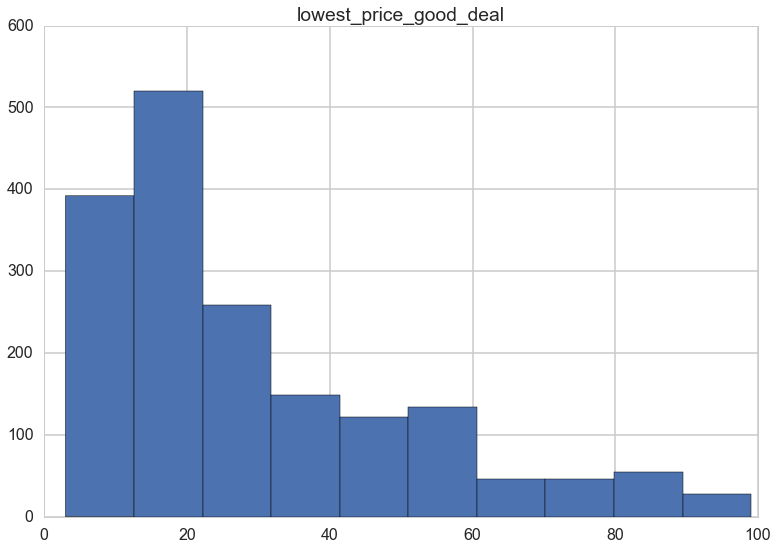

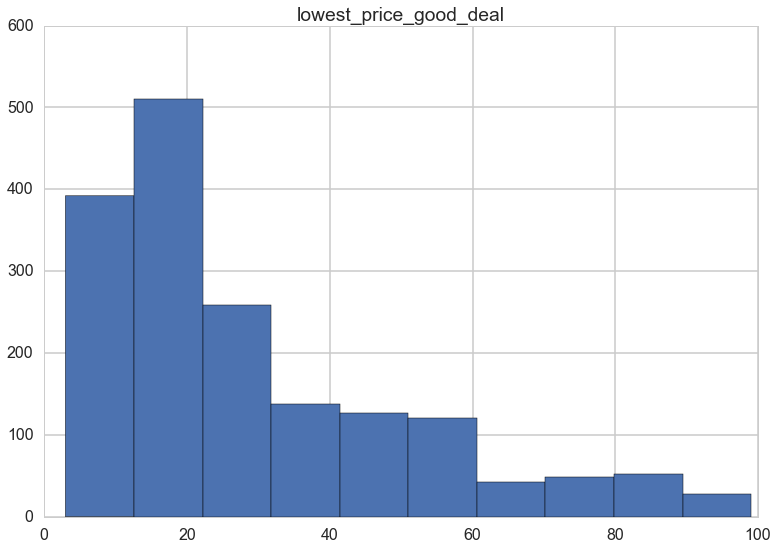

In [156]:
for x in frames:
    x[x['lowest_price_good_deal']<100].hist(column='lowest_price_good_deal')

In [157]:
friday=[]
lol=datetime.datetime.strptime('2015-12-04', '%Y-%m-%d')
while lol<datetime.datetime.strptime('2016-04-15', '%Y-%m-%d'):
    lol=lol + datetime.timedelta(days=7)
    friday.append(lol)

sunday=[]
lol=datetime.datetime.strptime('2015-12-06', '%Y-%m-%d')
while lol<datetime.datetime.strptime('2016-04-17', '%Y-%m-%d'):
    lol=lol + datetime.timedelta(days=7)
    sunday.append(lol)
    
weekend=[]
for x in range(len(friday)):
    weekend.append((str(friday[x]),str(sunday[x])))

We show the histogram for lowest price good deal. These graphs look right skewed. 

In [163]:
fulldf.head()

listing_count  avg_price  lowest_price_good  lowest_price  highest_price   city                venuename  venuescore  ticket_score       id   home_team           away_team  hometeamscore  awayteamscore     dateutc  daysaway  dateloaded  cntStars_home  WPCT_home  STRK_home  rankNBA_home  cntStars_away  WPCT_away  STRK_away  rankNBA_away  HomeAVG  HomePCT  AwayAVG  AwayPCT  TotalAVG  TotalPCT  Population  numTeams  holiday   weekday dateutcindateform
0            815         62                 20            20           1800  Miami  American Airlines Arena     0.85776       0.78884  2759732  Miami Heat      Boston Celtics        0.78556        0.74908  2015-12-01         2  2015-11-29              2      0.667          1             5              0      0.563          2            12    19659    100.3    16840     84.2     18720      94.9     5764000         4        0   Tuesday        2015-12-01
1           3431        146                 49            49           6505  Miami  American Airlines Arena     0.85776       0.84152  2759651  Miami Heat       Brooklyn Nets        0.78556        0.75524  2015-12-29        30  2015-11-29              2      0.667          1             5              3      0.188         -2            28    19659    100.3    16840     84.2     18720      94.9     5764000         4        0   Tuesday        2015-12-29
2           4093         76                 18            18           4435  Miami  American Airlines Arena     0.85776       0.82779  2759635  Miami Heat       Brooklyn Nets        0.78556        0.75524  2016-03-28       120  2015-11-29              2      0.667          1             5              3      0.188         -2            28    19659    100.3    16840     84.2     18720      94.9     5764000         4        0    Monday        2016-03-28
3           3886        125                 36            36           5914  Miami  American Airlines Arena     0.85776       0.84336  2759767  Miami Heat     New York Knicks        0.78556        0.81215  2016-01-07        39  2015-11-29              2      0.667          1             5              1      0.471         -3            19    19659    100.3    16840     84.2     18720      94.9     5764000         4        0  Thursday        2016-01-07
4           4046         78                 20            20           4140  Miami  American Airlines Arena     0.85776       0.83536  2759683  Miami Heat  Philadelphia 76ers        0.78556        0.70023  2016-03-06        98  2015-11-29              2      0.667          1             5              0      0.000        -17            30    19659    100.3    16840     84.2     18720      94.9     5764000         4        0    Sunday        2016-03-06

###1. Histogram of Lowest Good Ticket Prices

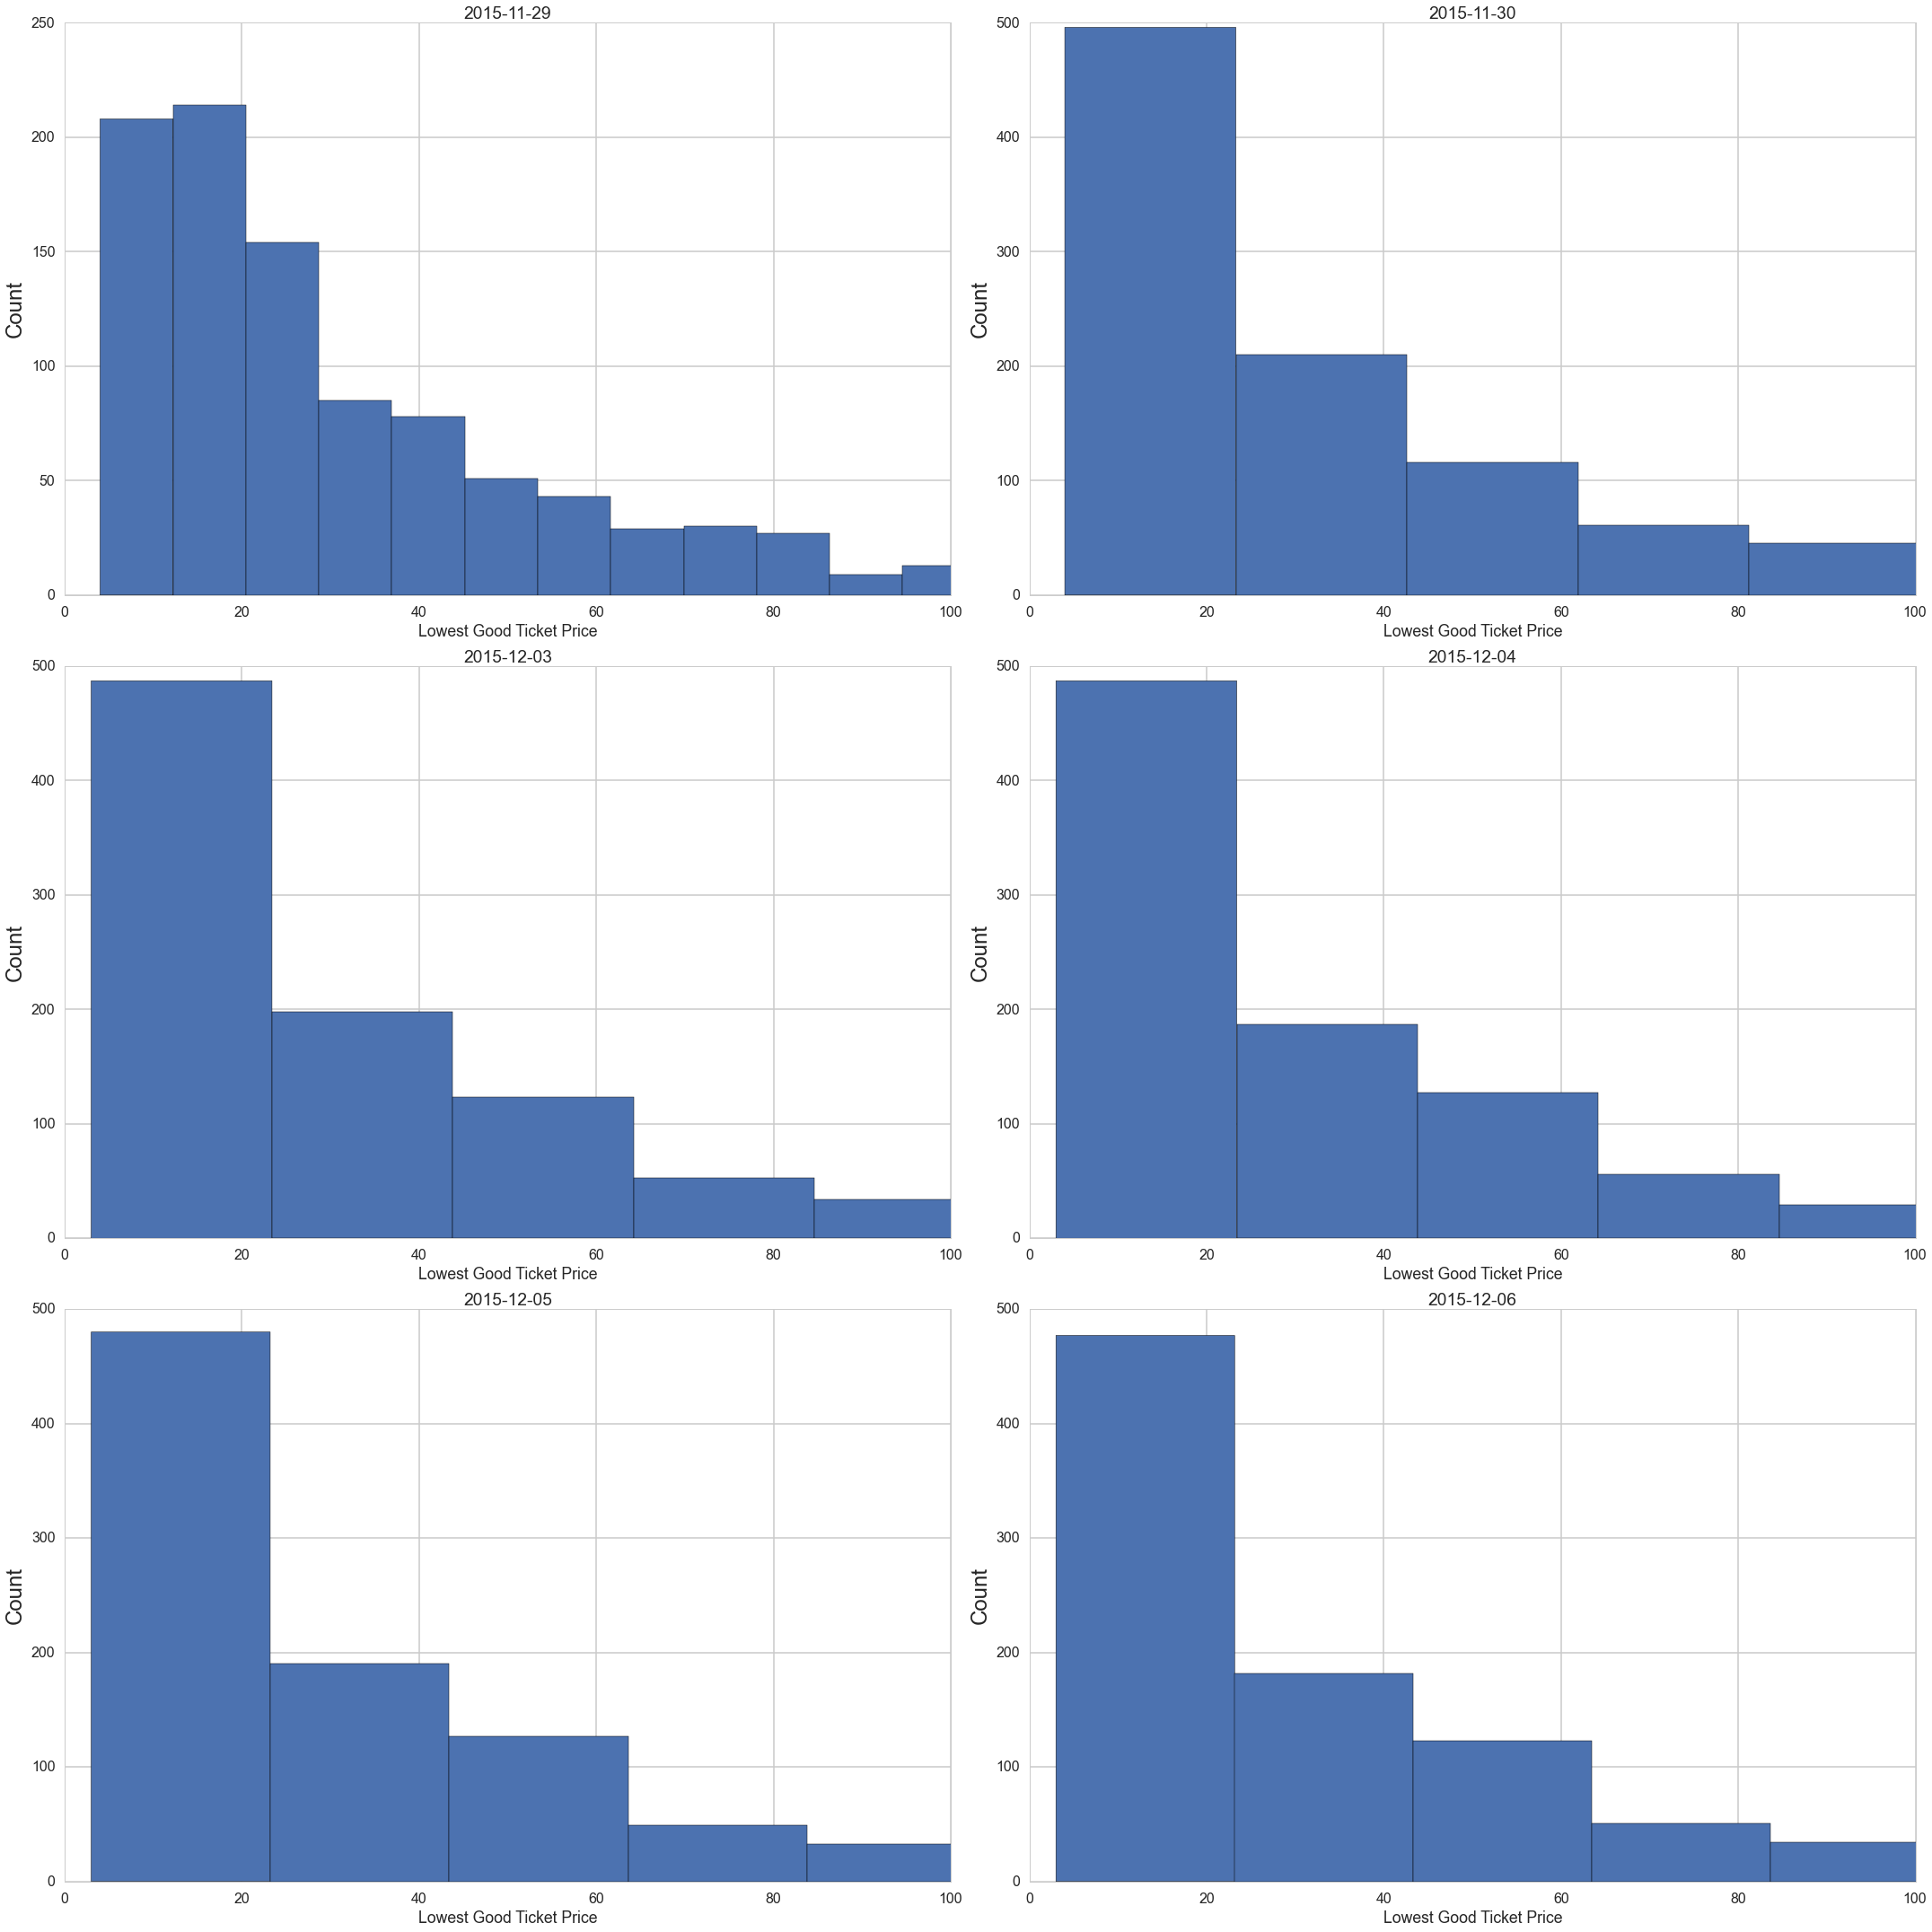

In [175]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(35, 50), tight_layout=True)

for ax, day in zip(axes.ravel(), fulldf.groupby('dateloaded')):
    #establish a figure
    plt.figure()
    day[1]['lowest_price_good'].plot(kind='hist', figsize=(30,30), ax=ax,bins=30)
    ax.set_title(day[0])
    ax.set_xlim(0,100)
    ax.set_xlabel('Lowest Good Ticket Price')
    ax.set_ylabel('Count',size=24)
    plt.close()
    

In [92]:
fulldf.head(2)

listing_count  avg_price  lowest_price_good  lowest_price  highest_price   city                venuename  venuescore  ticket_score       id   home_team       away_team  hometeamscore  awayteamscore     dateutc  daysaway  dateloaded  cntStars_home  WPCT_home  STRK_home  rankNBA_home  cntStars_away  WPCT_away  STRK_away  rankNBA_away  HomeAVG  HomePCT  AwayAVG  AwayPCT  TotalAVG  TotalPCT  Population  numTeams  holiday  weekday dateutcindateform
0            815         62                 20            20           1800  Miami  American Airlines Arena     0.85776       0.78884  2759732  Miami Heat  Boston Celtics        0.78556        0.74908  2015-12-01         2  2015-11-29              2      0.667          1             5              0      0.563          2            12    19659    100.3    16840     84.2     18720      94.9     5764000         4        0  Tuesday        2015-12-01
1           3431        146                 49            49           6505  Miami  American Airlines Arena     0.85776       0.84152  2759651  Miami Heat   Brooklyn Nets        0.78556        0.75524  2015-12-29        30  2015-11-29              2      0.667          1             5              3      0.188         -2            28    19659    100.3    16840     84.2     18720      94.9     5764000         4        0  Tuesday        2015-12-29

In [176]:
fulldf=pd.read_csv('cleanedFulldf.csv', index_col=0)
fulldf['dateutc'] = fulldf['dateutc'].astype('datetime64')
fulldf = fulldf.drop('dateutcindateform', 1)

###2. Away Team Rank and Ticket Price

Plot the lowest price good, ranking of away teams and ranking of away teams in the same graph. 

You can see that if the ranking of the away team becomes bigger(30th rather than 20th), the ticket price increases as well. This means that generally there is an inversely proportional relationship between the away team ranking and ticket price.


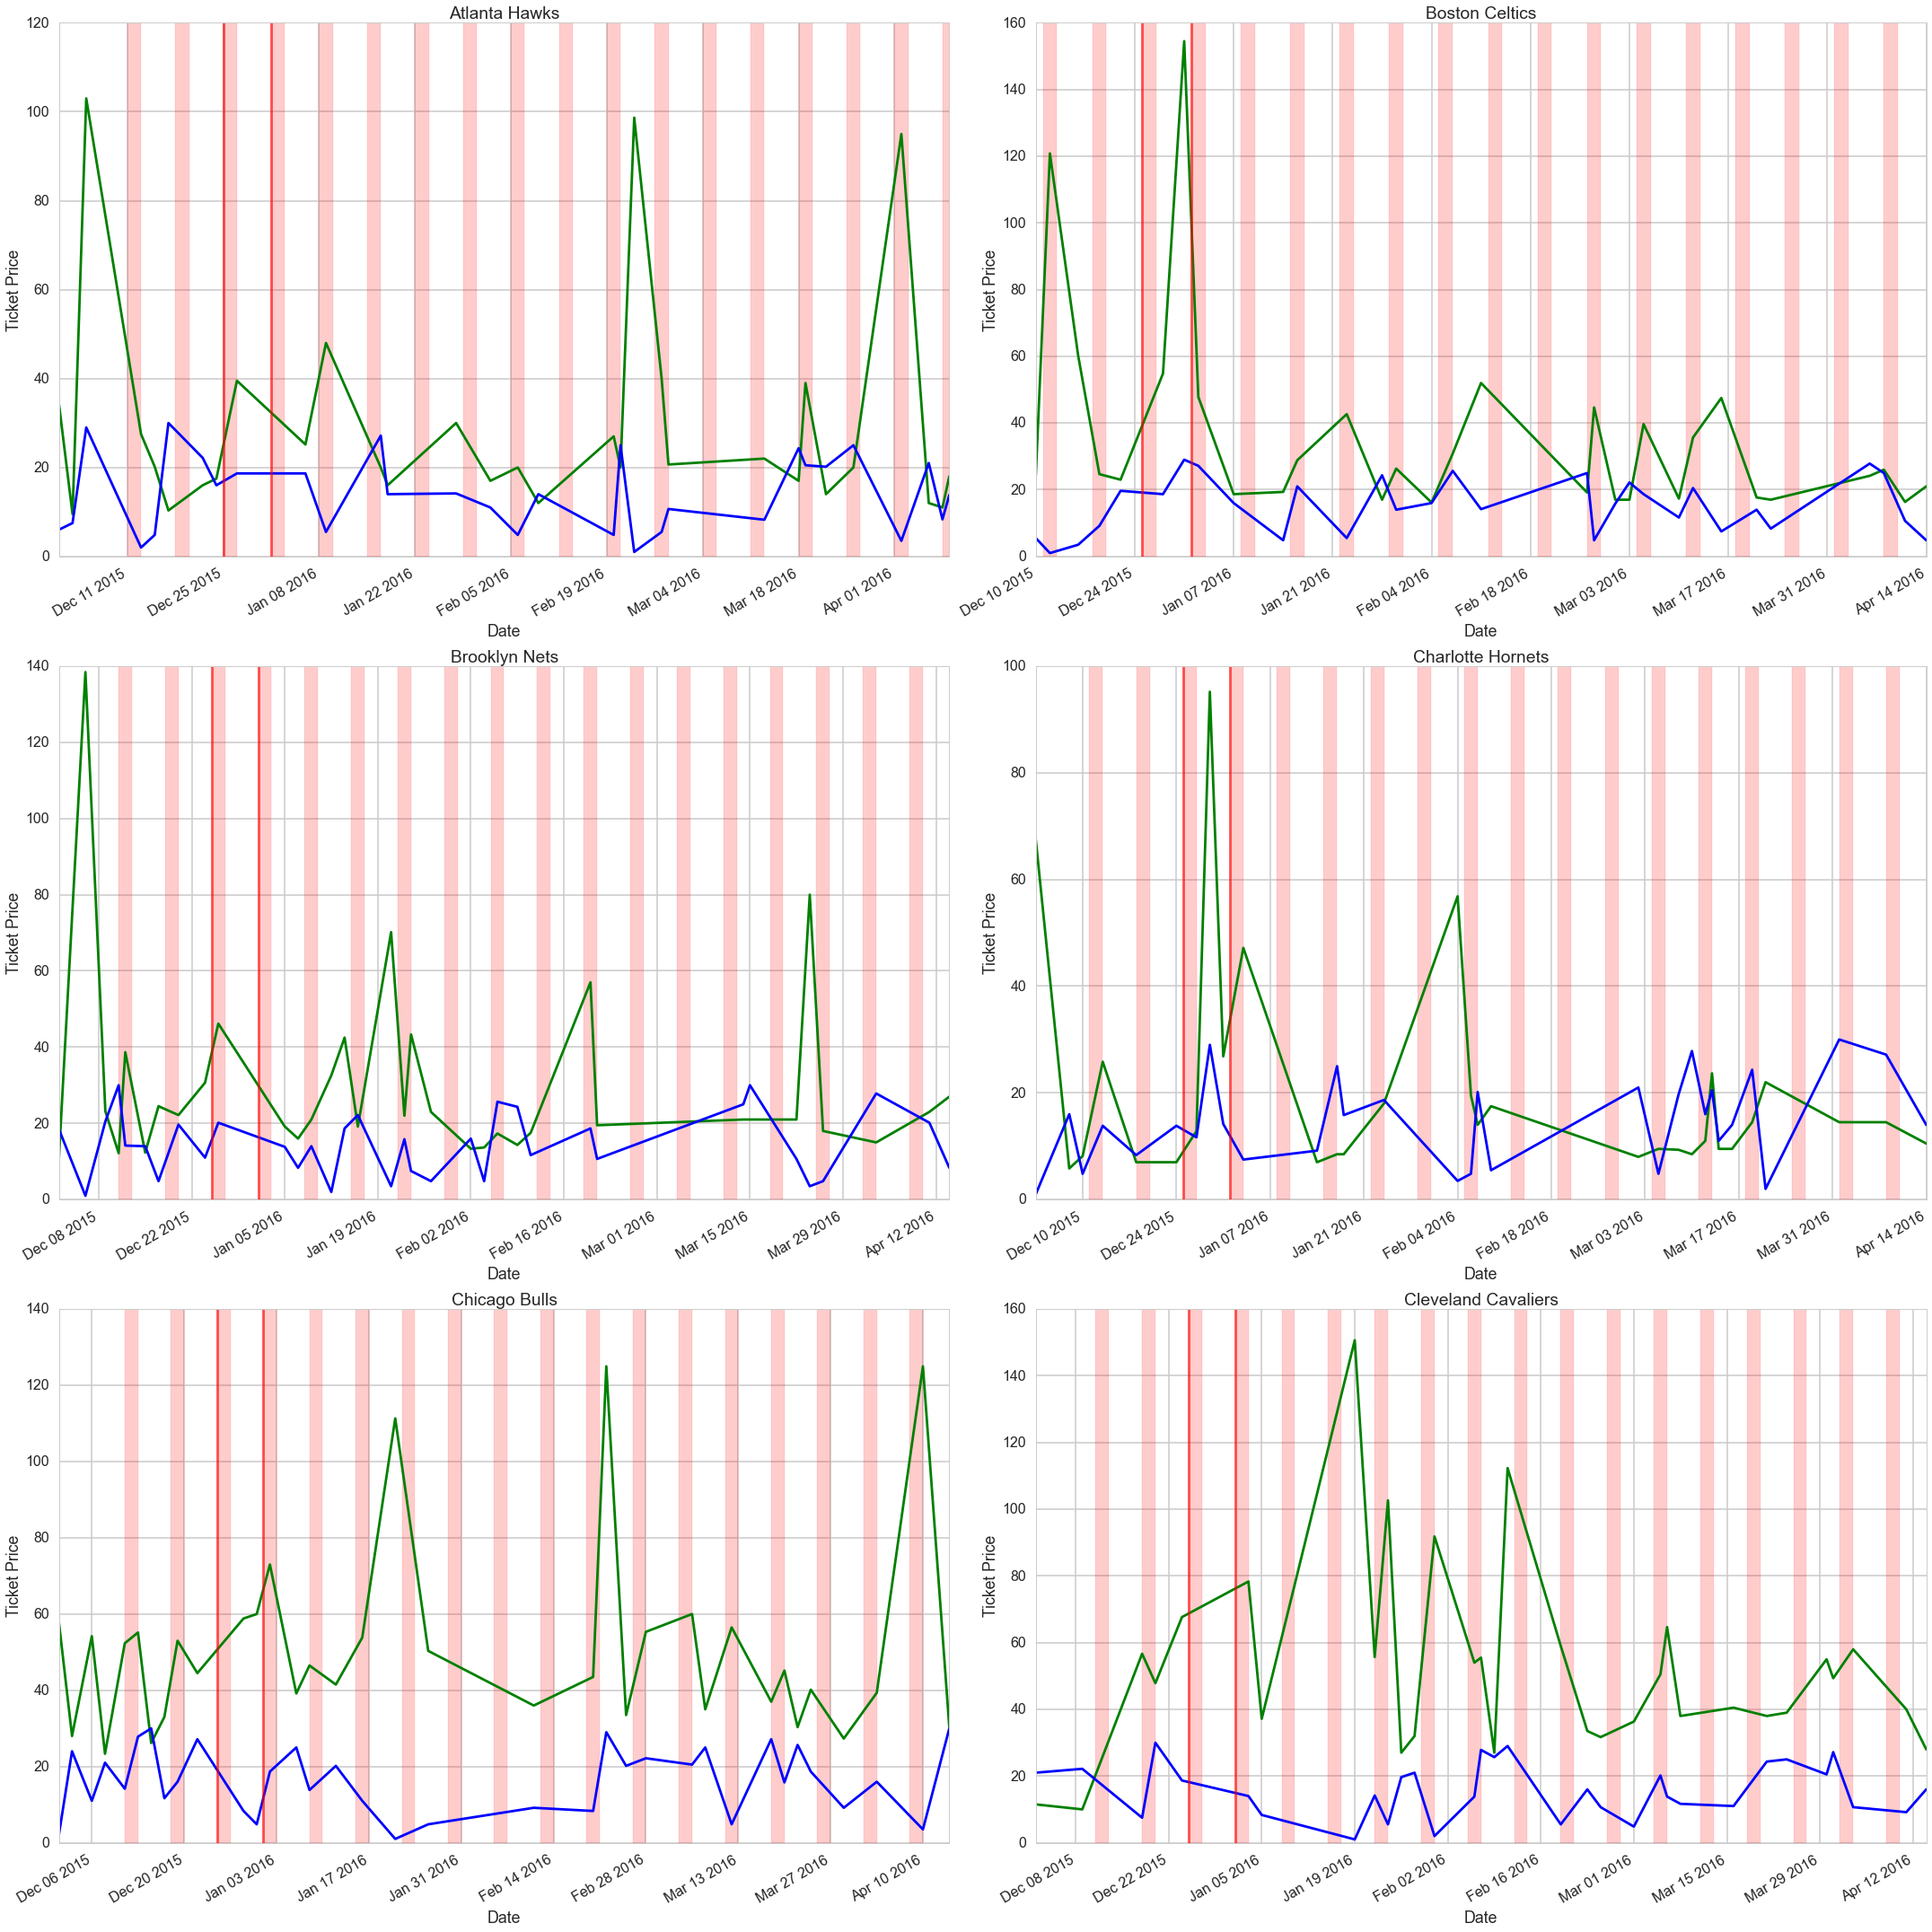

In [199]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(35, 50), tight_layout=True)

for ax, team in zip(axes.ravel(), fulldf.groupby('home_team')):
    #establish a figure
    plt.figure()
    team[1].groupby('dateutc').mean()['lowest_price_good'].plot(figsize=(30,30), ax=ax,color='green')
#     team[1].groupby('dateutc').mean()['rankNBA_home'].plot(figsize=(30,30), ax=ax,color='g')
    team[1].groupby('dateutc').mean()['rankNBA_away'].plot(figsize=(30,30), ax=ax,color='b')

    ax.axvline(x='2015-12-25', color='red', alpha=0.6, linewidth=3, label='Christmas')    
    ax.axvline(x='2016-01-01', color='red', alpha=0.6, linewidth=3, label='New Years')
    ax.axvspan('2015-11-26', '2015-11-29', color='red', alpha=0.2)
    for x in range(len(weekend)):
        ax.axvspan(weekend[x][0], weekend[x][1], color='red', alpha=0.2)
    
    ax.set_title(team[0])
    ax.set_xlabel('Date')
    ax.set_ylabel('Ticket Price')
    plt.close()

###3. Ticket Price Change By Team

The following graphs show how the ticket price changes over time. Holidays (Christmas and New Years) are shown by red vertical lines, and red shaded regions show a Friday-Sunday weekend. In this case, red lines are Christmas and New Years's Day.


It is easy to see the change of price over time of all the teams. The ticket price is more expensive on holidays than on weekdays. Especially the ticket price between Christmas and New Year's Day is generally more expensive than usual.


You also see weak teams like Sacramento Kings, Milwaukee Bucks, and Washington Wizards who are not seeing the effect of holidays and weekend as much as Golden State Warrors.

We suspect while holidays and weekends do play a part, we have to look at team performance information to explain this discrepancy. 

Lakers show a rise in ticket price towards the end of the season; it might be that people want to see Kobe Bryant, a NBA legend, play before he retires this season.

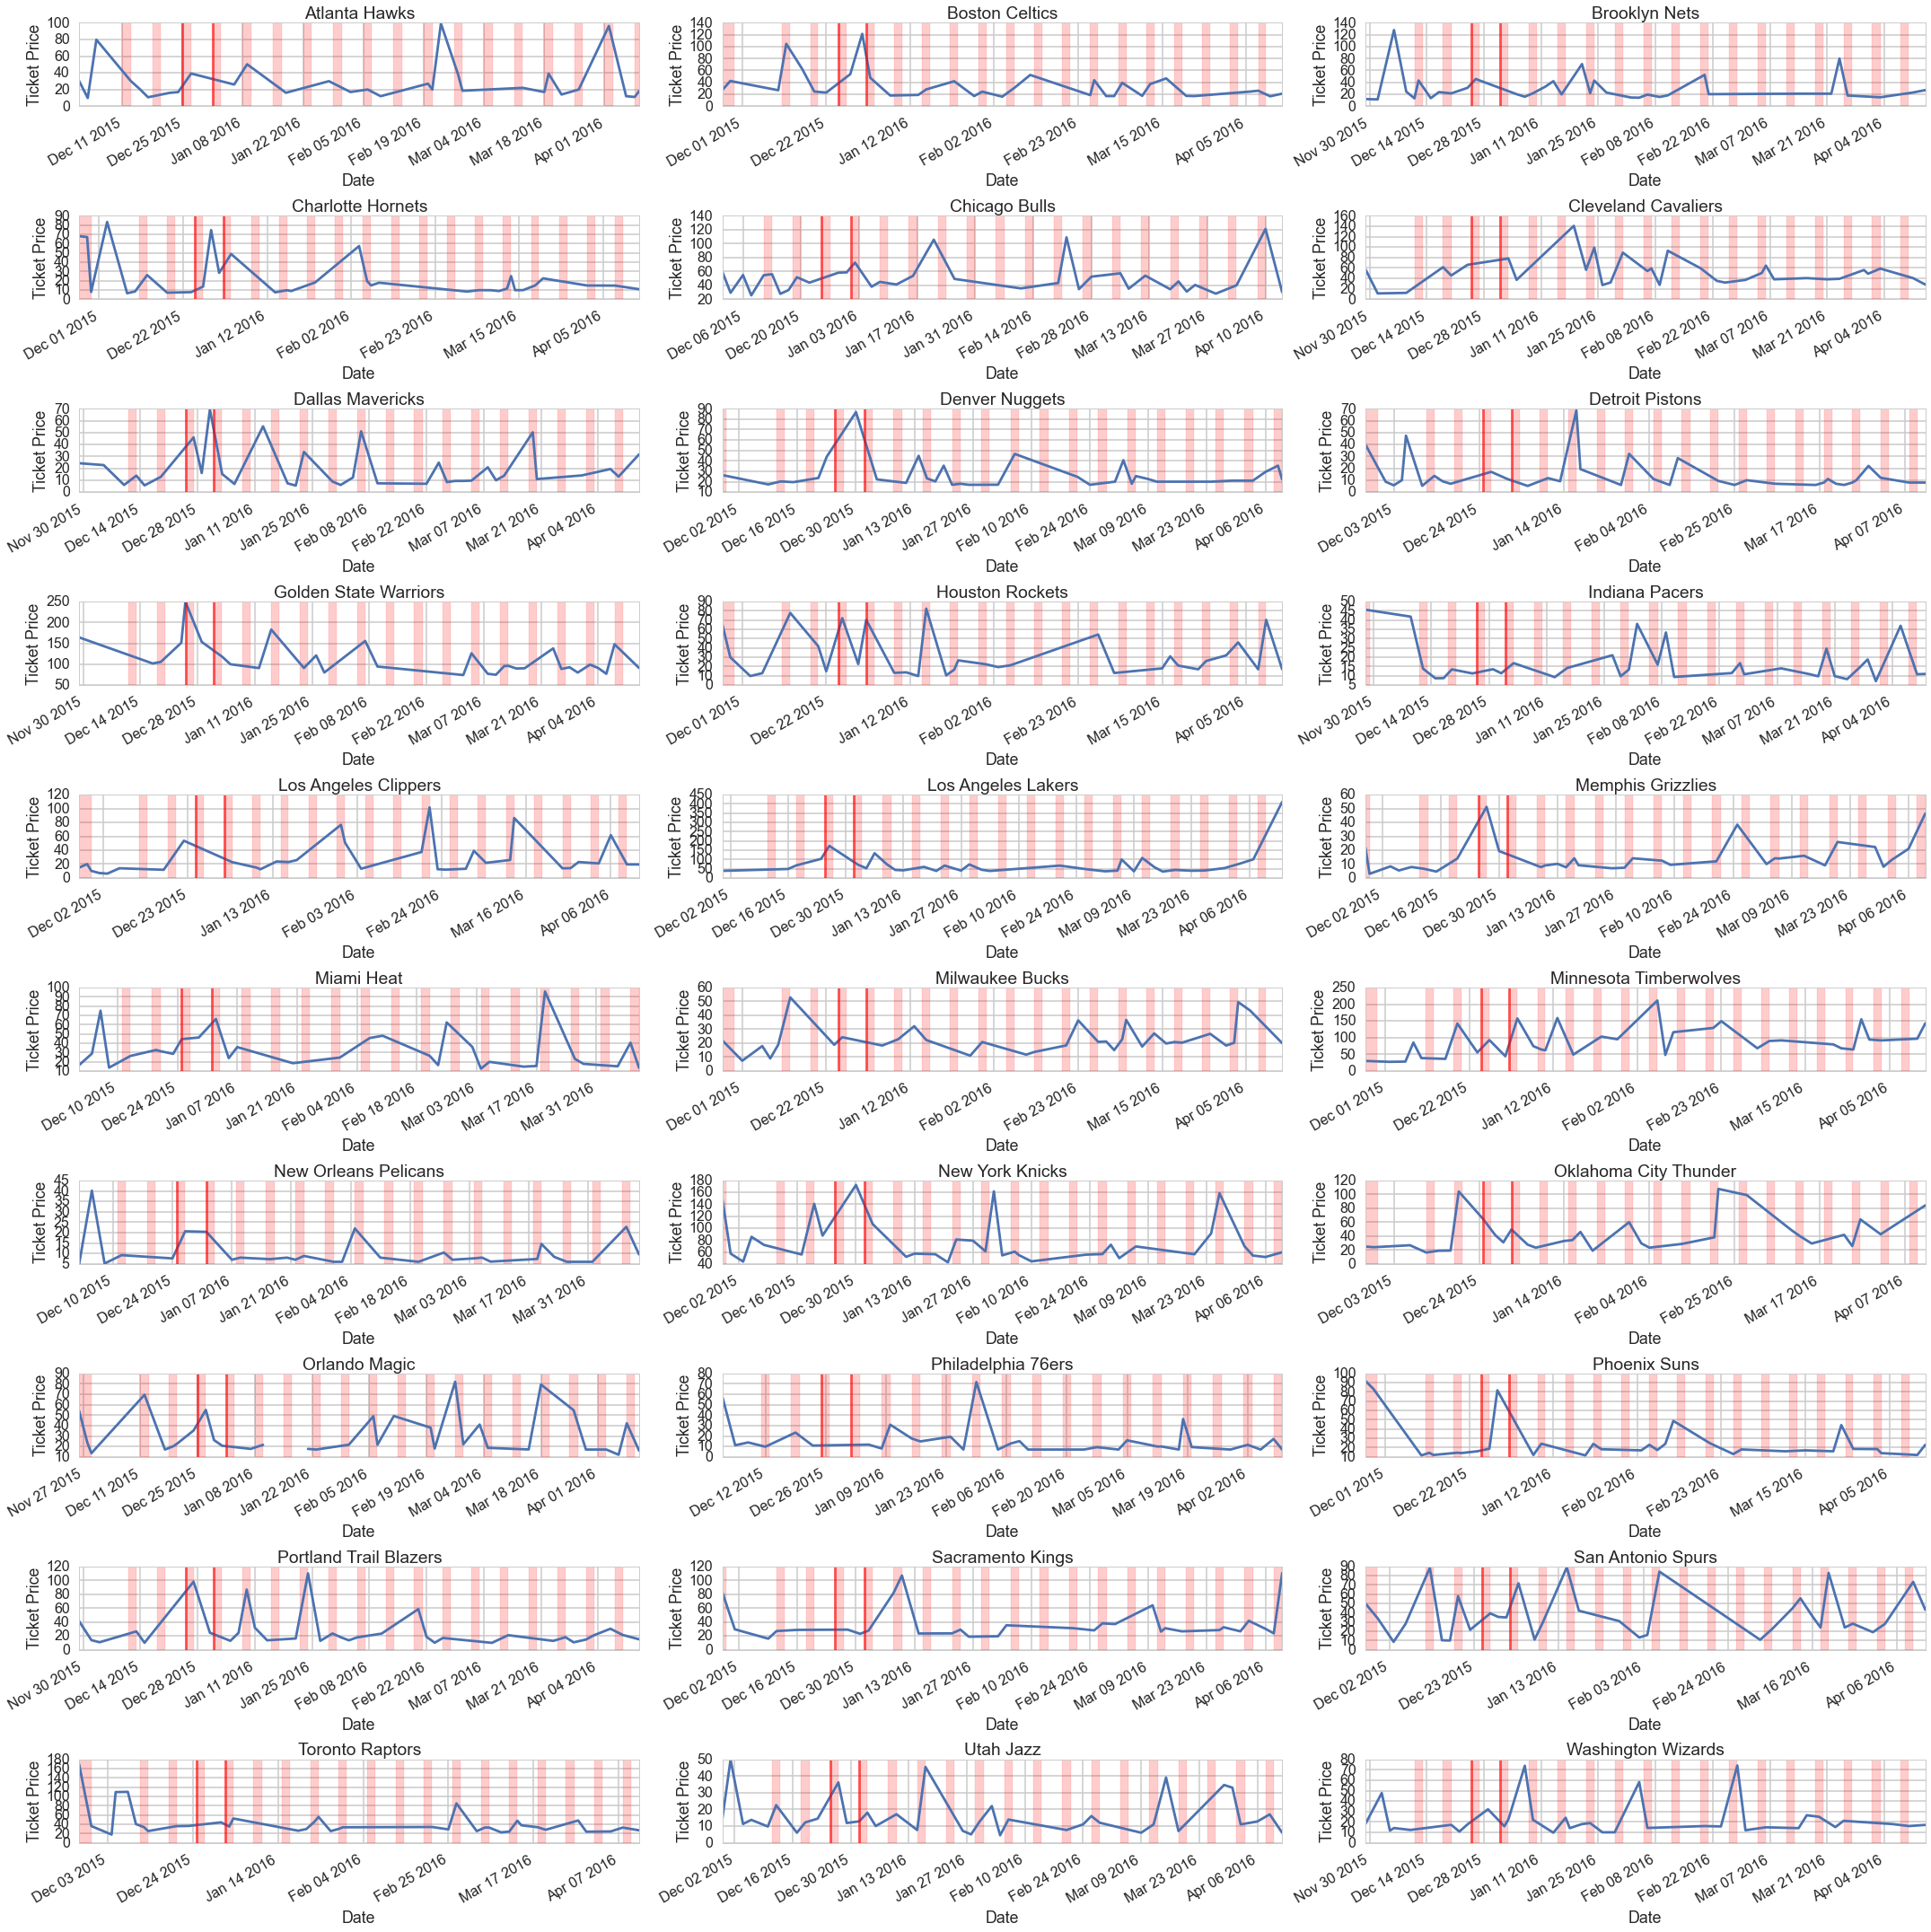

In [80]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(35, 50), tight_layout=True)

for ax, team in zip(axes.ravel(), tickets.groupby('home_team')):
    #establish a figure
    plt.figure()
    team[1].groupby('dateutc').mean()['lowest_price_good_deal'].plot(figsize=(30,30), ax=ax)
    ax.axvline(x='2015-12-25', color='red', alpha=0.6, linewidth=3, label='Christmas')    
    ax.axvline(x='2016-01-01', color='red', alpha=0.6, linewidth=3, label='New Years')
    ax.axvspan('2015-11-26', '2015-11-29', color='red', alpha=0.2)
    for x in range(len(weekend)):
        ax.axvspan(weekend[x][0], weekend[x][1], color='red', alpha=0.2)
    
    ax.set_title(team[0])
    ax.set_xlabel('Date')
    ax.set_ylabel('Ticket Price')
    plt.close()

###4. Time Evolution of Lowest Good Ticket Price per NBA Teams

The following graph shows "Time Evolution of Lowest Good Ticket Price per NBA Teams". 

It is now easy to see that ticket price on holidays is more expensive than on weekdays.

The price on weekdays does not seem to have a pattern. The price of Monday games does not look cheaper or more expensive than the price of Thursday games.


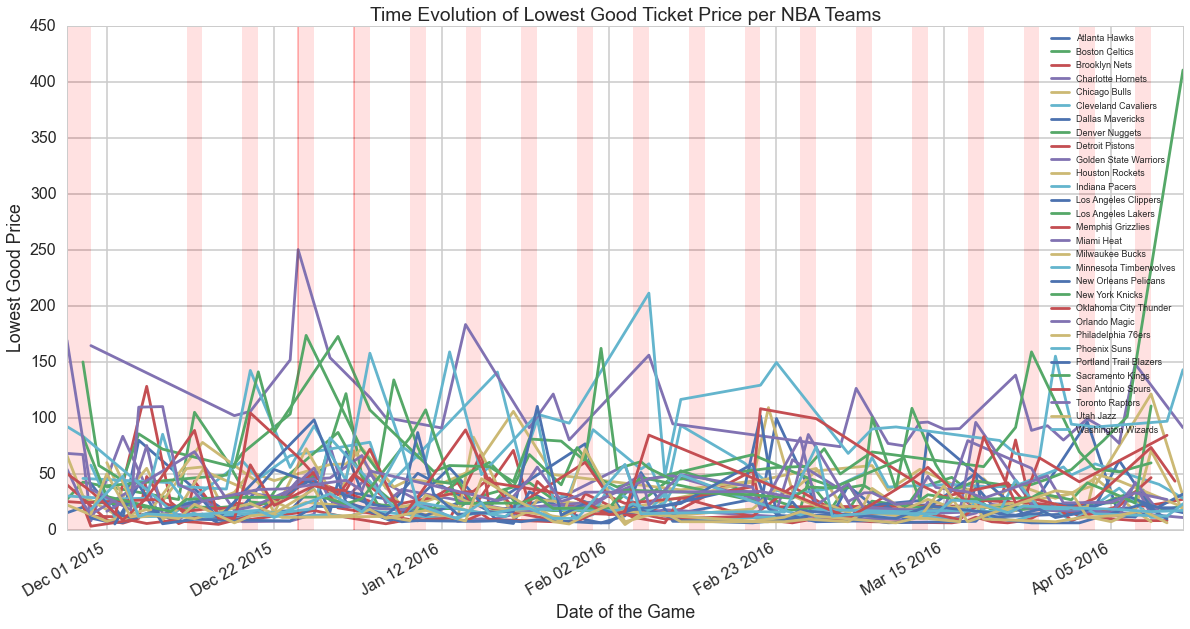

In [81]:
plt.figure()

for k, df in tickets.groupby('home_team'):
    df.groupby('dateutc').mean()['lowest_price_good_deal'].plot(label=k, figsize=(20,10))
    plt.legend(loc='best', prop={'size':9})    
    plt.axvline(x='2015-12-25', color='red', alpha=0.06, linewidth=0.3)    
    plt.axvline(x='2016-01-01', color='red', alpha=0.06, linewidth=0.3)
    plt.axvspan('2015-11-26', '2015-11-29', color='red', alpha=0.002)

    for x in range(len(weekend)):
        plt.axvspan(weekend[x][0], weekend[x][1], color='red', alpha=0.002)

plt.xlabel("Date of the Game")
plt.ylabel("Lowest Good Price")
plt.title("Time Evolution of Lowest Good Ticket Price per NBA Teams")
plt.show()

###5. Single Factor Analysis

Next we want to show how individual factors affect the ticket price. 

The graph shows the inversely proportional relationship between the lowest good price and the number of tickets.

As the number of tickets increases, the lowest good price decreases usually. The graph shows that as the the number of tickets decreases, the lowest good price increases usually. 


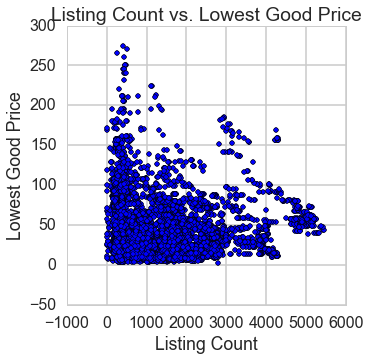

In [82]:
#effect of listing on ticket price
plt.figure(figsize=(5,5))
plt.scatter(tickets[tickets['lowest_price_good_deal']<500]['listing_count'] ,tickets[tickets['lowest_price_good_deal']<500]['lowest_price_good_deal'])
plt.xlabel("Listing Count")
plt.ylabel("Lowest Good Price")
plt.title("Listing Count vs. Lowest Good Price")
plt.show()

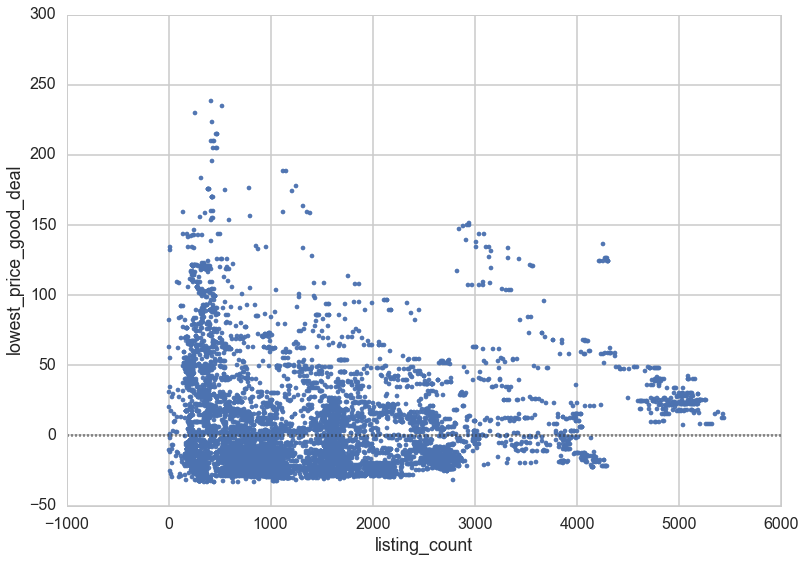

In [83]:
sns.residplot("listing_count", "lowest_price_good_deal", data=tickets[tickets['lowest_price_good_deal']<500])
plt.show()

###6. Ticket For Each Team

First we show how the lowest good ticket price changes over time. 

Tickets for games within a week are usually more expensive. Most of the tickets of each team seem stable after a week except Christmas season. During that season, tickets become expensive for most of the teams.

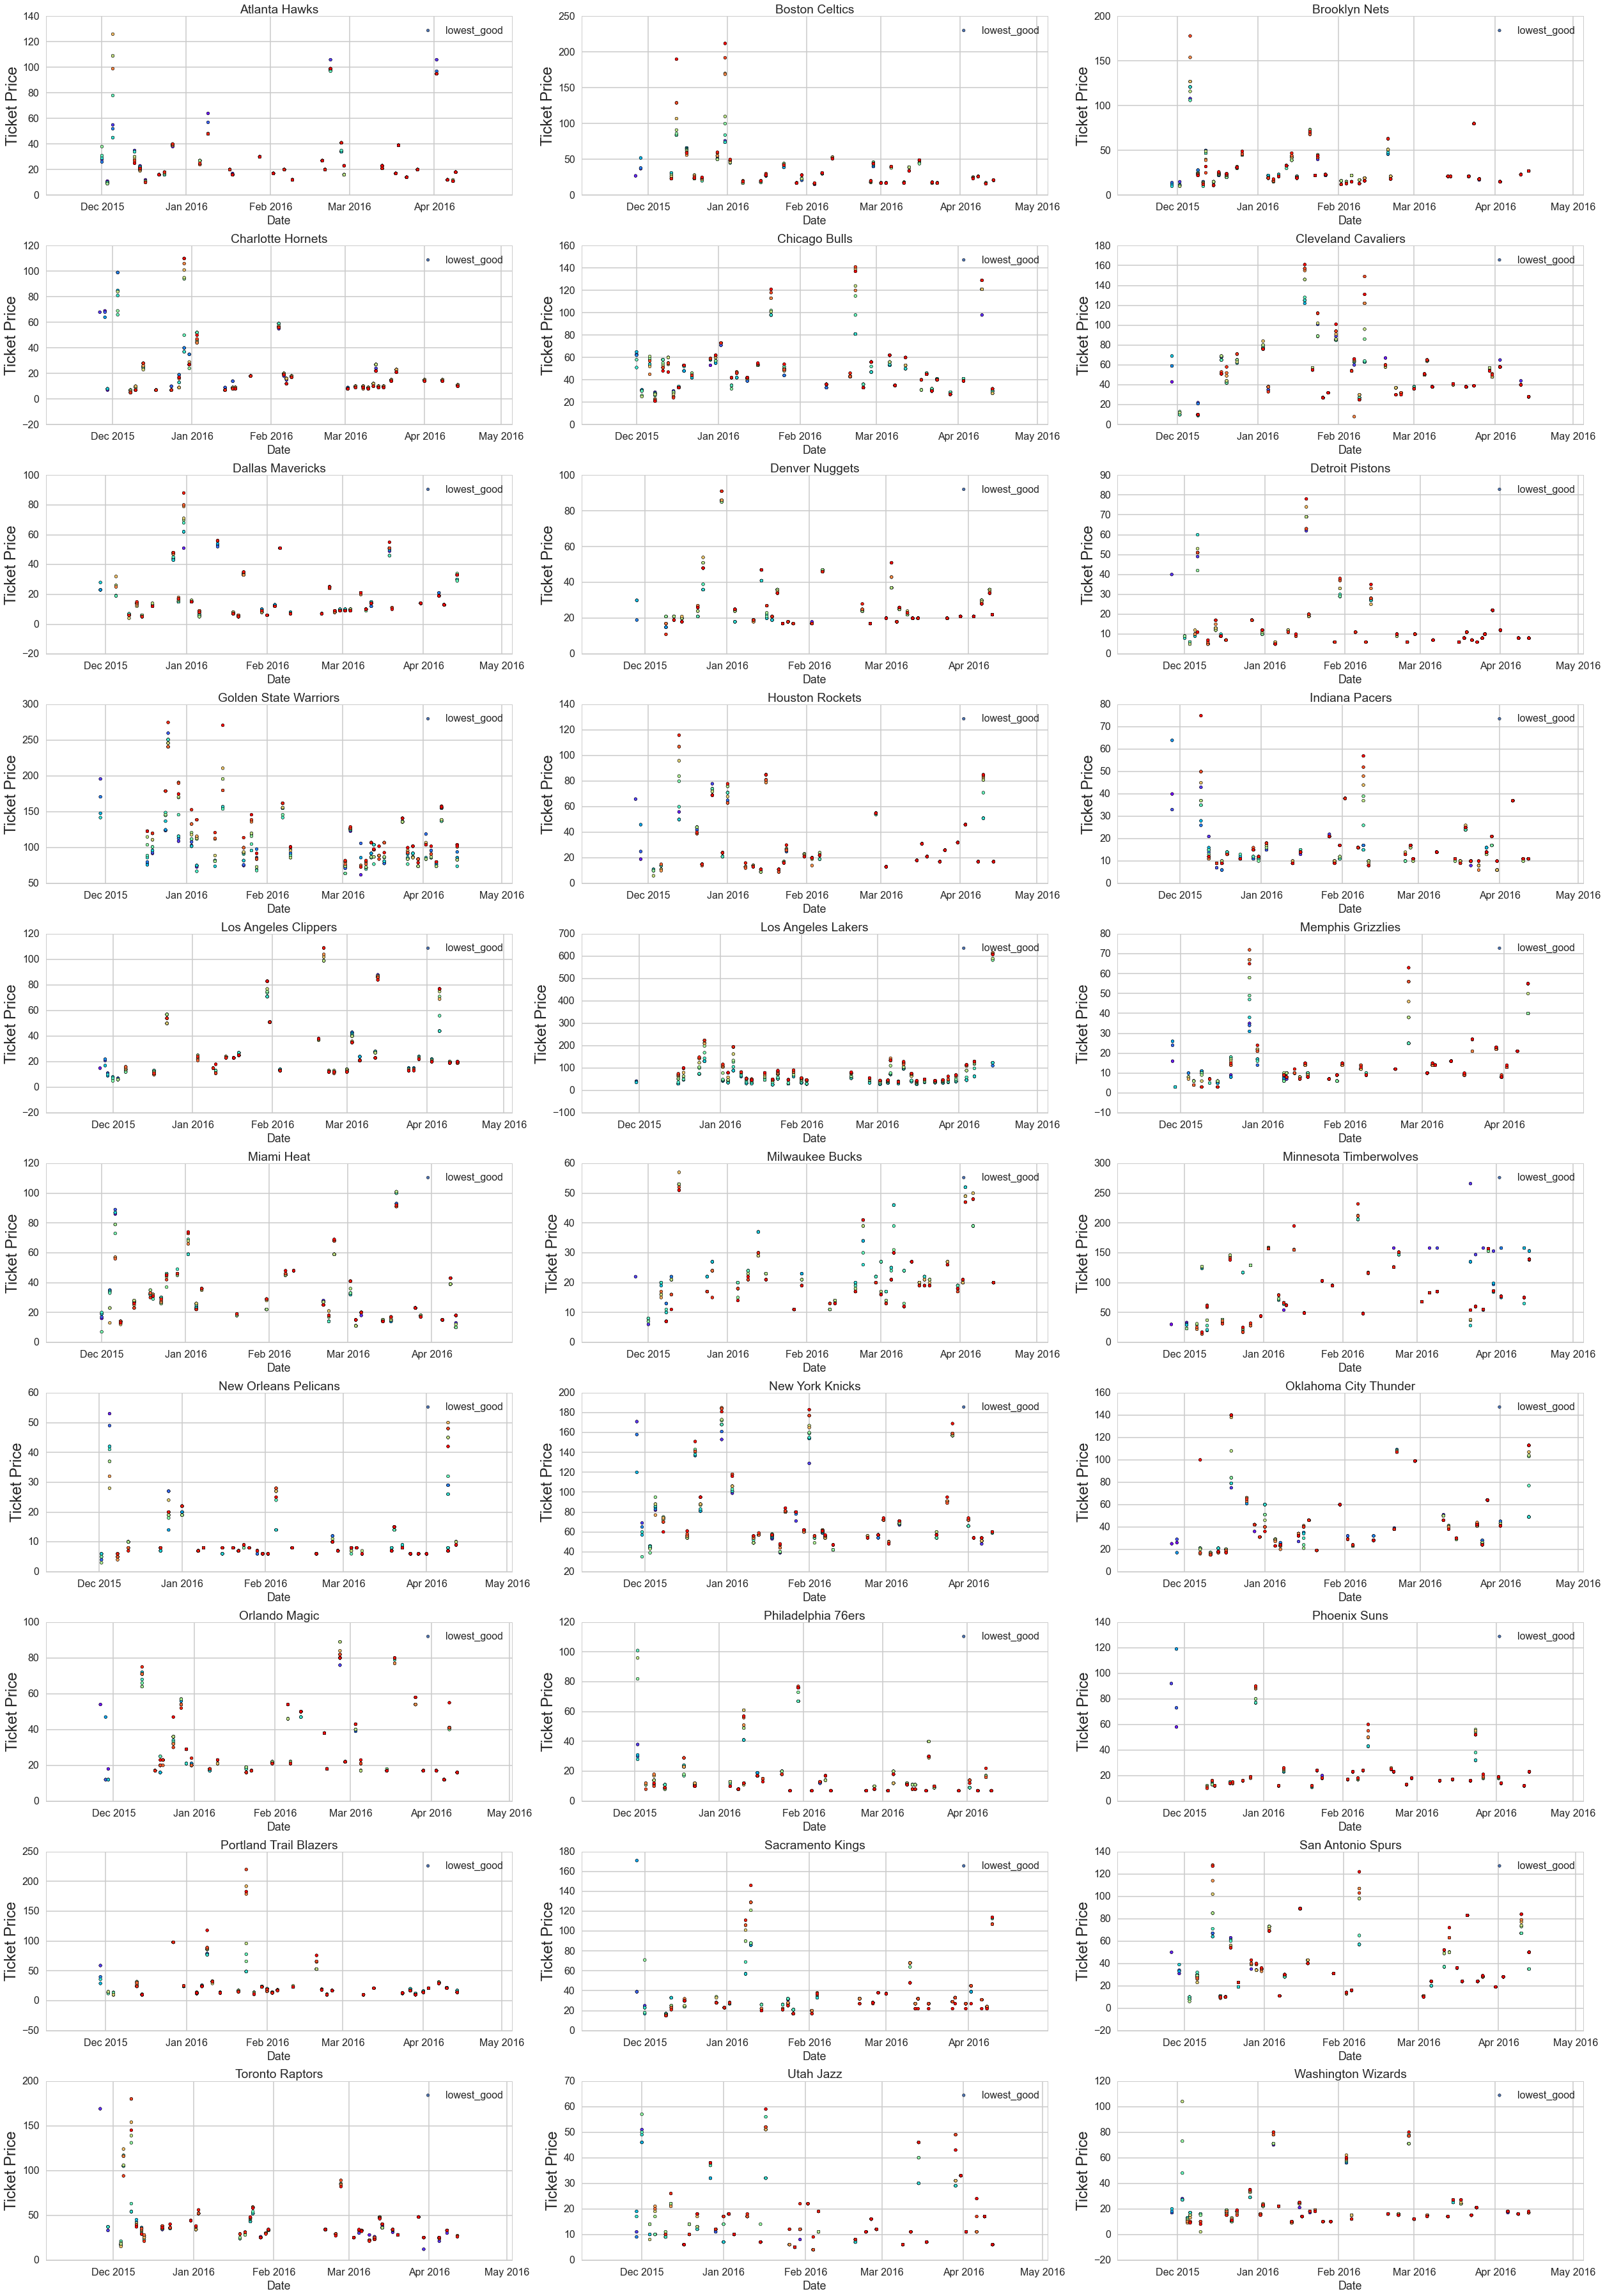

In [96]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(35, 50), tight_layout=True)

for ax, team in zip(axes.ravel(), tickets.groupby('home_team')):
    #establish a figure
    plt.figure()
    #ax.scatter(team[1]['dateutc'].values, team[1]['avg_price'].values, alpha=1,  c=np.linspace(0,10,len(team[1])), cmap='rainbow', label='avg')
    ax.scatter(team[1]['dateutc'].values, team[1]['lowest_price_good_deal'].values, alpha=1, c=np.linspace(0,10,len(team[1])), cmap='rainbow',  label='lowest_good')
    #ax.scatter(team[1]['dateutc'].values, team[1]['lowest_price'].values, alpha=0.5, c=np.linspace(0,10,len(team[1])), cmap='rainbow', label='min')
    ax.set_title(team[0])
    ax.legend(loc='best')
    ax.set_xlabel('Date')
    ax.set_ylabel('Ticket Price',size=24)
    plt.close()

###7. Number of Available Tickets for Each Team

Next we would like to show how the number of available tickets changes over time rather than the price of tickets.

The number of tickets are few if the game is within a week. However, the number of available tickets stays almost the same after one week. This makes sense because there is an inversely proportional relationship between the lowest good price and the number of tickets. Thus if there are few tickets available, the price tends to become higher.

Lakers are not as stable as other teams. One of the reasons for this is the retirement of Kobe Bryant. 

Golden State Warriors does not have many available tickets probably because they are playing very well this year and tickets start to be sold out quickly.

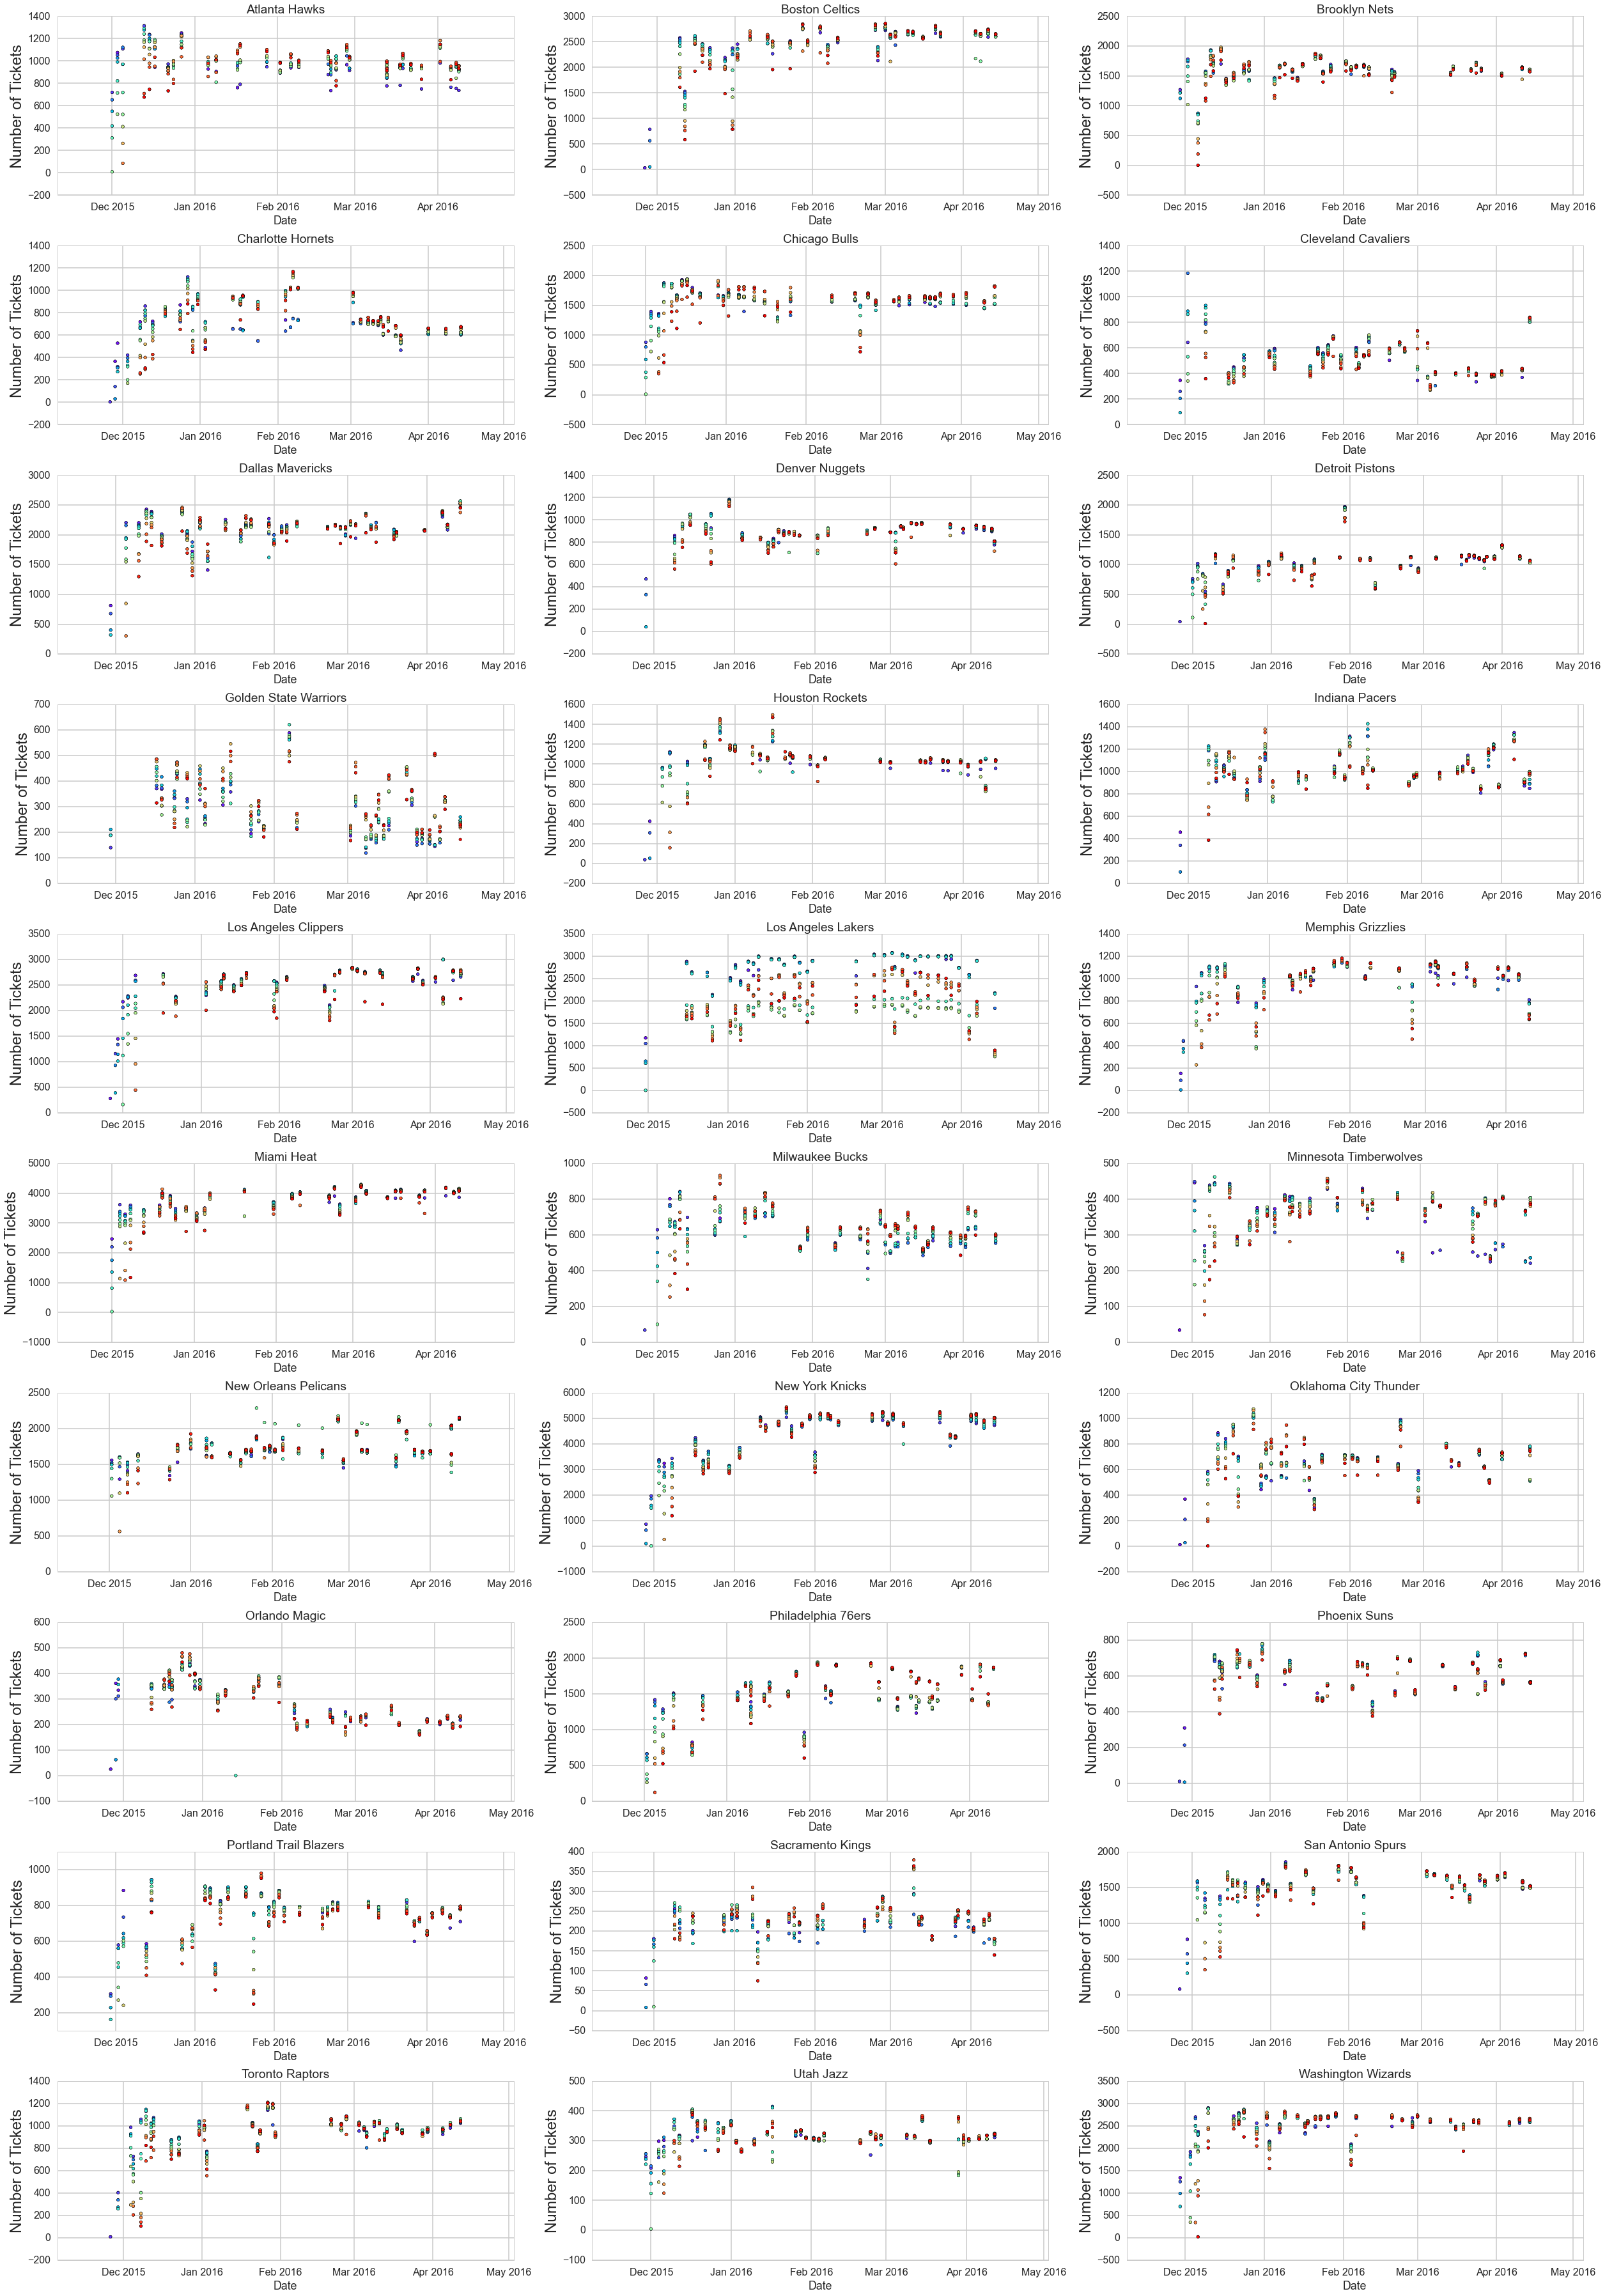

In [95]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(35, 50), tight_layout=True)

for ax, team in zip(axes.ravel(), tickets.groupby('home_team')):
    #establish a figure
    plt.figure()
    ax.scatter(team[1]['dateutc'].values, team[1]['listing_count'].values, c=np.linspace(0,10,len(team[1])), cmap='rainbow')

    ax.set_title(team[0])
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Tickets',size=24)
    plt.close()